In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager
from math import sqrt
import sklearn
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import RFE, SequentialFeatureSelector, SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from hyperopt import fmin, tpe, hp, Trials
from bayes_opt import BayesianOptimization
import re, ast



import warnings
warnings.filterwarnings('ignore')

font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()

plt.rcParams["font.family"] = font_family
plt.rcParams["axes.unicode_minus"] = False


%matplotlib inline

In [33]:
df = pd.read_csv('apartment_20230831.csv')

In [34]:
drop_col = ['아파트명','법정동주소','현관구조','위도','경도','임대세대수','지하철역','역사명']

In [35]:
filtered_df = df.dropna(subset=['용적률', '건폐율'])
filtered_df.drop(drop_col, axis=1, inplace=True)
filtered_df.dropna(inplace=True)
filtered_df['입주예정연도'] = filtered_df['입주예정연도'].astype(str)
filtered_df.reset_index(drop=True, inplace=True)

In [36]:
# 노선명을 추출하여 리스트로 저장
filtered_df['노선명_리스트'] = filtered_df['노선명_리스트'].apply(ast.literal_eval)
all_rail = set(rail for rail_list in filtered_df['노선명_리스트'] for rail in rail_list)

# MultiLabelBinarizer를 사용하여 원핫인코딩 수행
mlb = MultiLabelBinarizer()
encoded_routes = mlb.fit_transform(filtered_df['노선명_리스트'])
encoded_routes_df = pd.DataFrame(encoded_routes, columns=mlb.classes_)

# 원핫인코딩 결과를 원래 데이터프레임과 병합
df_encoded = pd.concat([filtered_df, encoded_routes_df], axis=1)
df_encoded.drop('노선명_리스트', axis=1, inplace=True)
df_encoded.keys()

Index(['세대수', '최고층', '최저층', '최대공급면적', '최소공급면적', '총아파트동수', '용적률', '건폐율',
       '세대평균_주차대수', '공급면적', '전용면적', '전용율', '방수', '욕실수', '입주예정연도', '공급액(만원)',
       '대형건설사', '지하철역_거리', '1차병원', '2차병원', '3차병원', '공원', '대학', '광역', '기초',
       '소매', '음식', '교육', '장례식장', '보건의료', '유원지오락', '총인구수', '투기과열지구_after',
       '분양가상한제_after', '투기과열지구_before', '분양가상한제_before', '시군구내_통근통학',
       '타시군구_통근통학', '타시군구/시군구내', '평당_공급액', '타입', '1호선', '2호선', '3호선', '4호선',
       '5호선', '6호선', '7호선', '8호선', '9호선', '경강선', '경의중앙선', '경춘선', '김포골드라인',
       '분당선', '서해선', '수인선', '신림선', '신분당선', '에버라인', '우이신설선', '의정부선', '인천국제공항선',
       '인천지하철 1호선', '인천지하철 2호선'],
      dtype='object')

In [37]:
df_encoded['기초'] = df_encoded['광역'] +'_'+ df_encoded['기초']

In [38]:
df_encoded = pd.get_dummies(df_encoded, columns=['입주예정연도','광역','기초'])

In [39]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2853 entries, 0 to 2852
Columns: 137 entries, 세대수 to 기초_인천_중구
dtypes: bool(1), float64(20), int32(24), int64(17), uint8(75)
memory usage: 1.3 MB


In [40]:
df_encoded.to_csv('reg_data_real_final.csv', index=False)

In [41]:
df_encoded = pd.read_csv('reg_data_real_final.csv')

In [42]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2853 entries, 0 to 2852
Columns: 137 entries, 세대수 to 기초_인천_중구
dtypes: bool(1), float64(20), int64(116)
memory usage: 3.0 MB


In [43]:
one_hot_encoded_columns = df_encoded.columns[df_encoded.isin([0, 1]).all()]

In [44]:
y_val_col = ['공급액(만원)', '평당_공급액']

In [45]:
drop_x_col = ['전용면적', '시군구내_통근통학', '타시군구_통근통학']

In [46]:
df_y_drop = df_encoded.drop(y_val_col, axis=1)
df_y_drop2 = df_y_drop.drop(drop_x_col, axis=1)
con_list = df_y_drop.drop(one_hot_encoded_columns, axis=1).columns

### 시각화

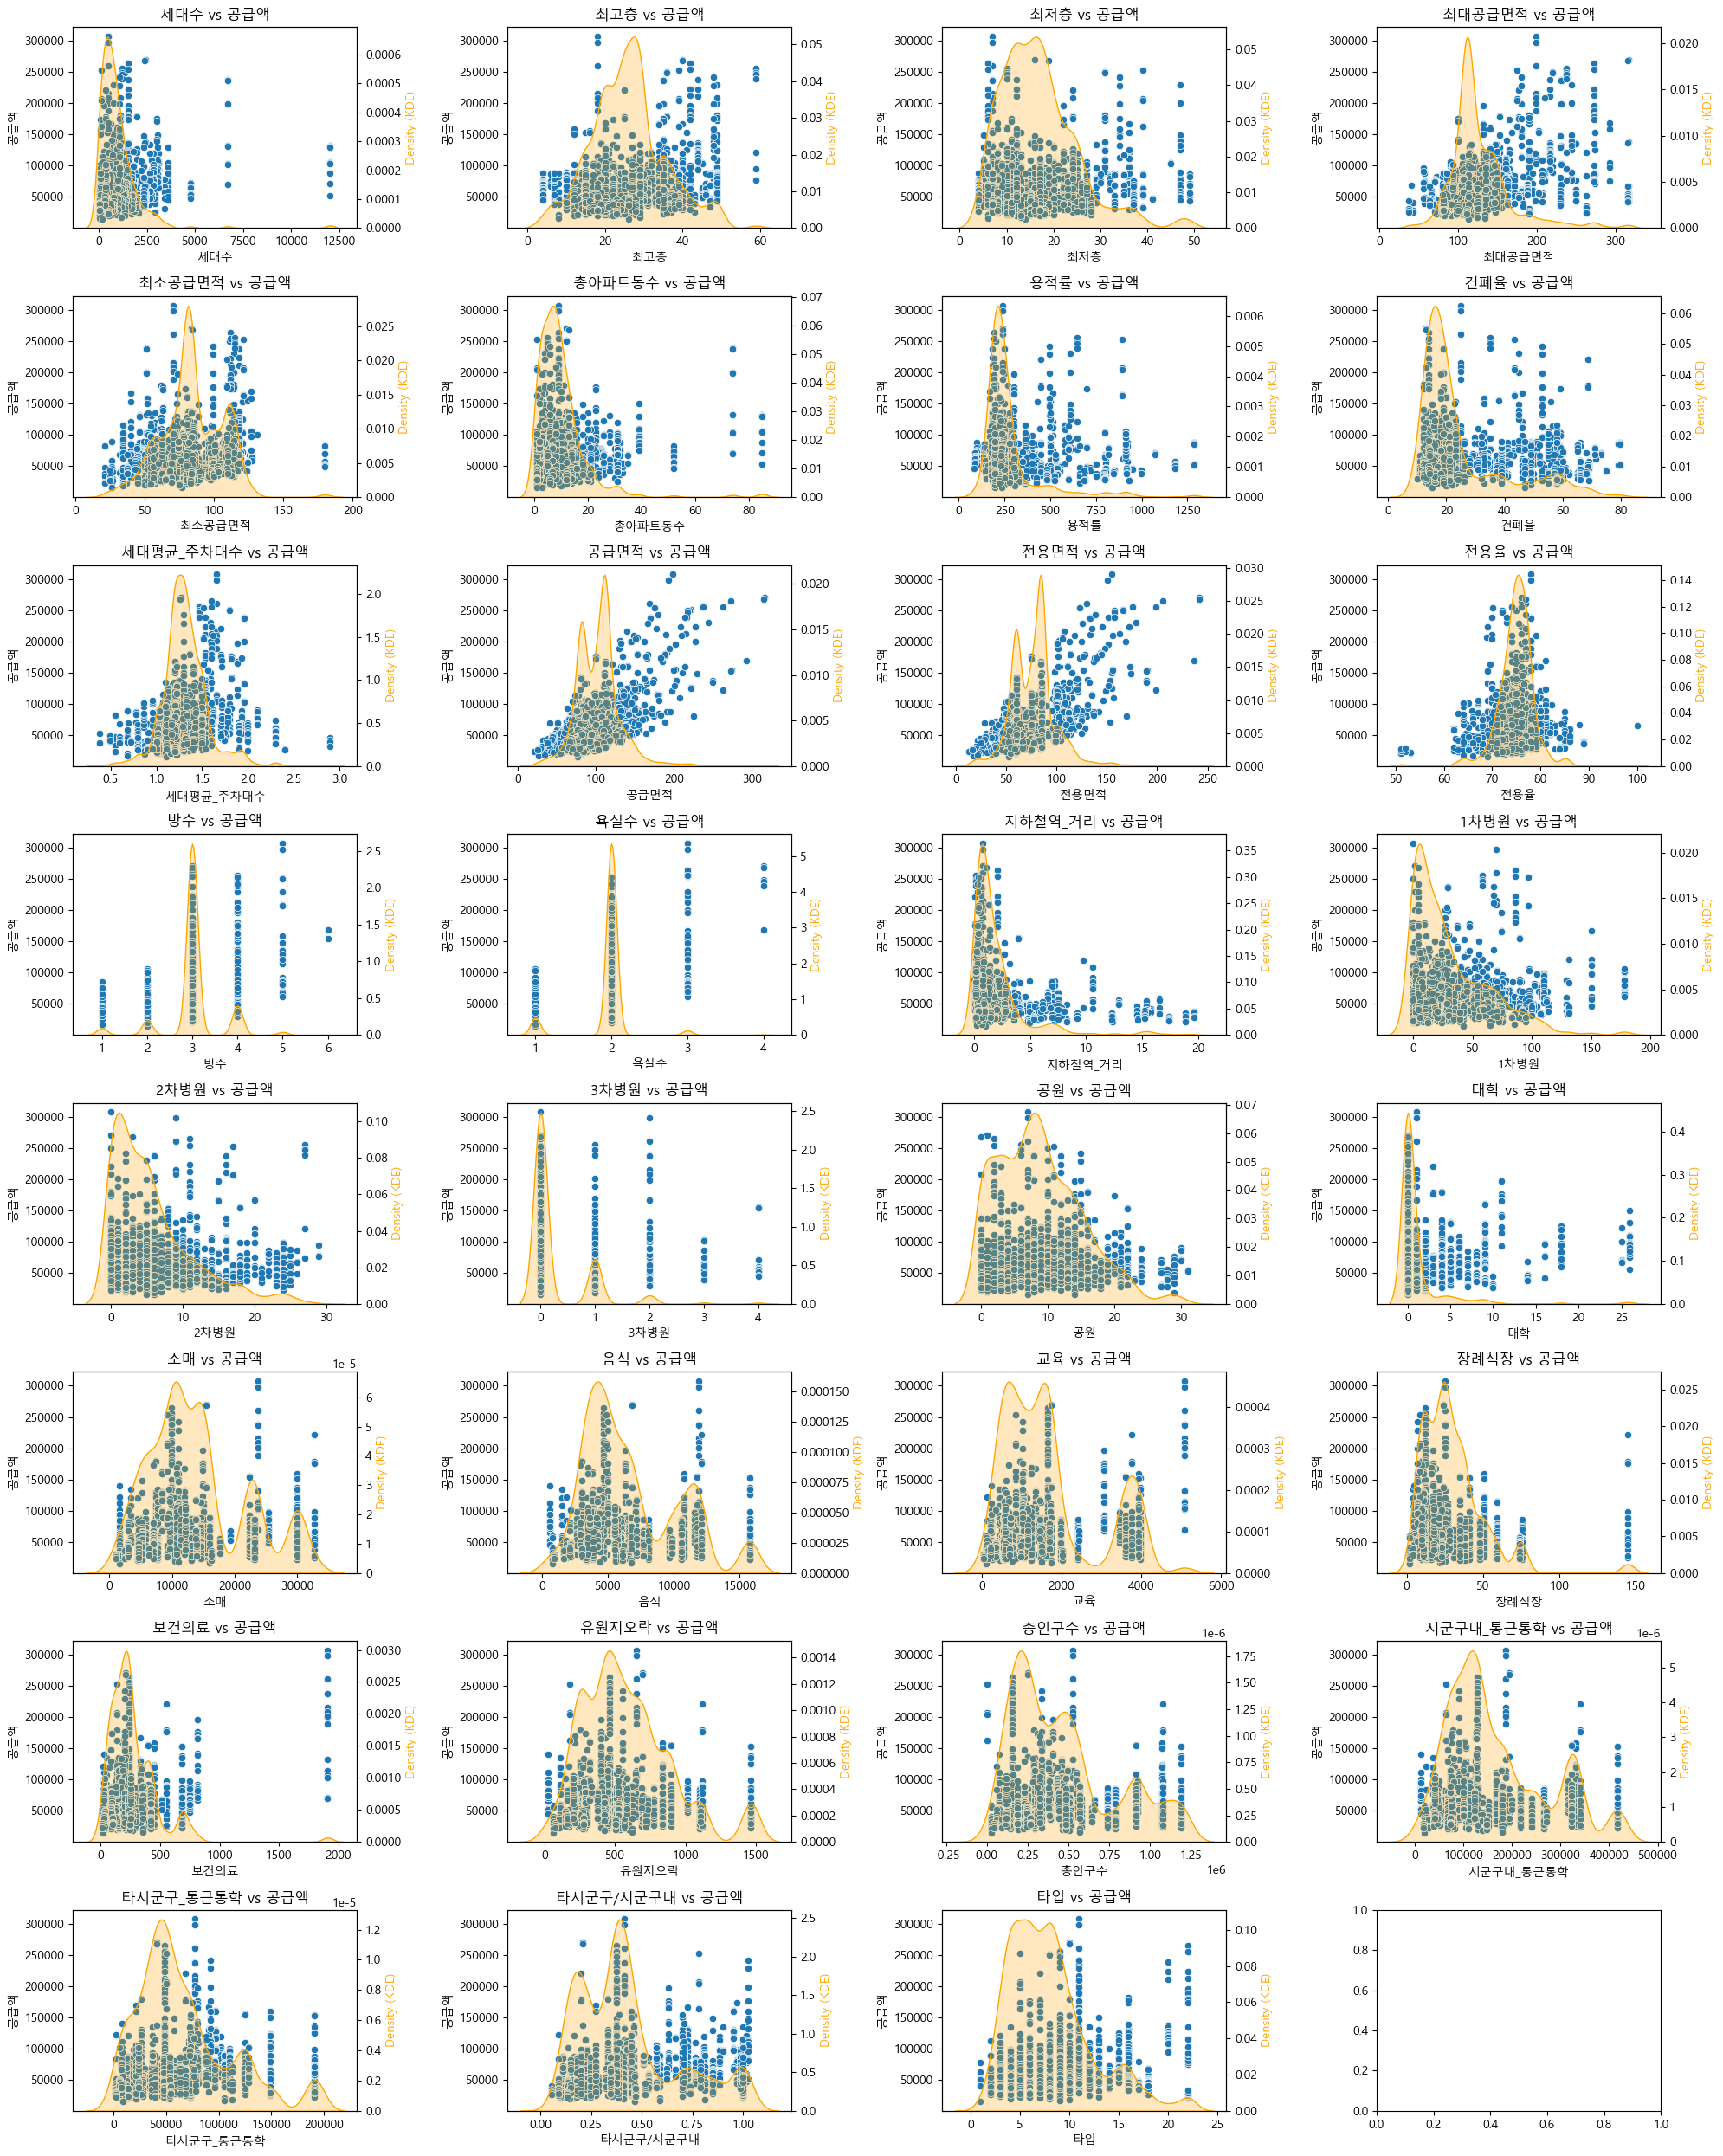

In [82]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 25))

for i, col in enumerate(df_encoded[con_list].columns):  
    row_idx = i // 4
    col_idx = i % 4
    ax = axes[row_idx, col_idx]
    
    sns.scatterplot(x=df_encoded[col], y=df_encoded[y_val_col[0]], ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel('공급액')
    ax.set_title(f'{col} vs 공급액')
    
    # Twin the axes for two different y-axes on the same plot
    ax2 = ax.twinx()
    sns.kdeplot(df_encoded[col], shade=True, ax=ax2, color='orange')
    ax2.set_ylabel('Density (KDE)', color='orange')
    
plt.tight_layout()
plt.show()

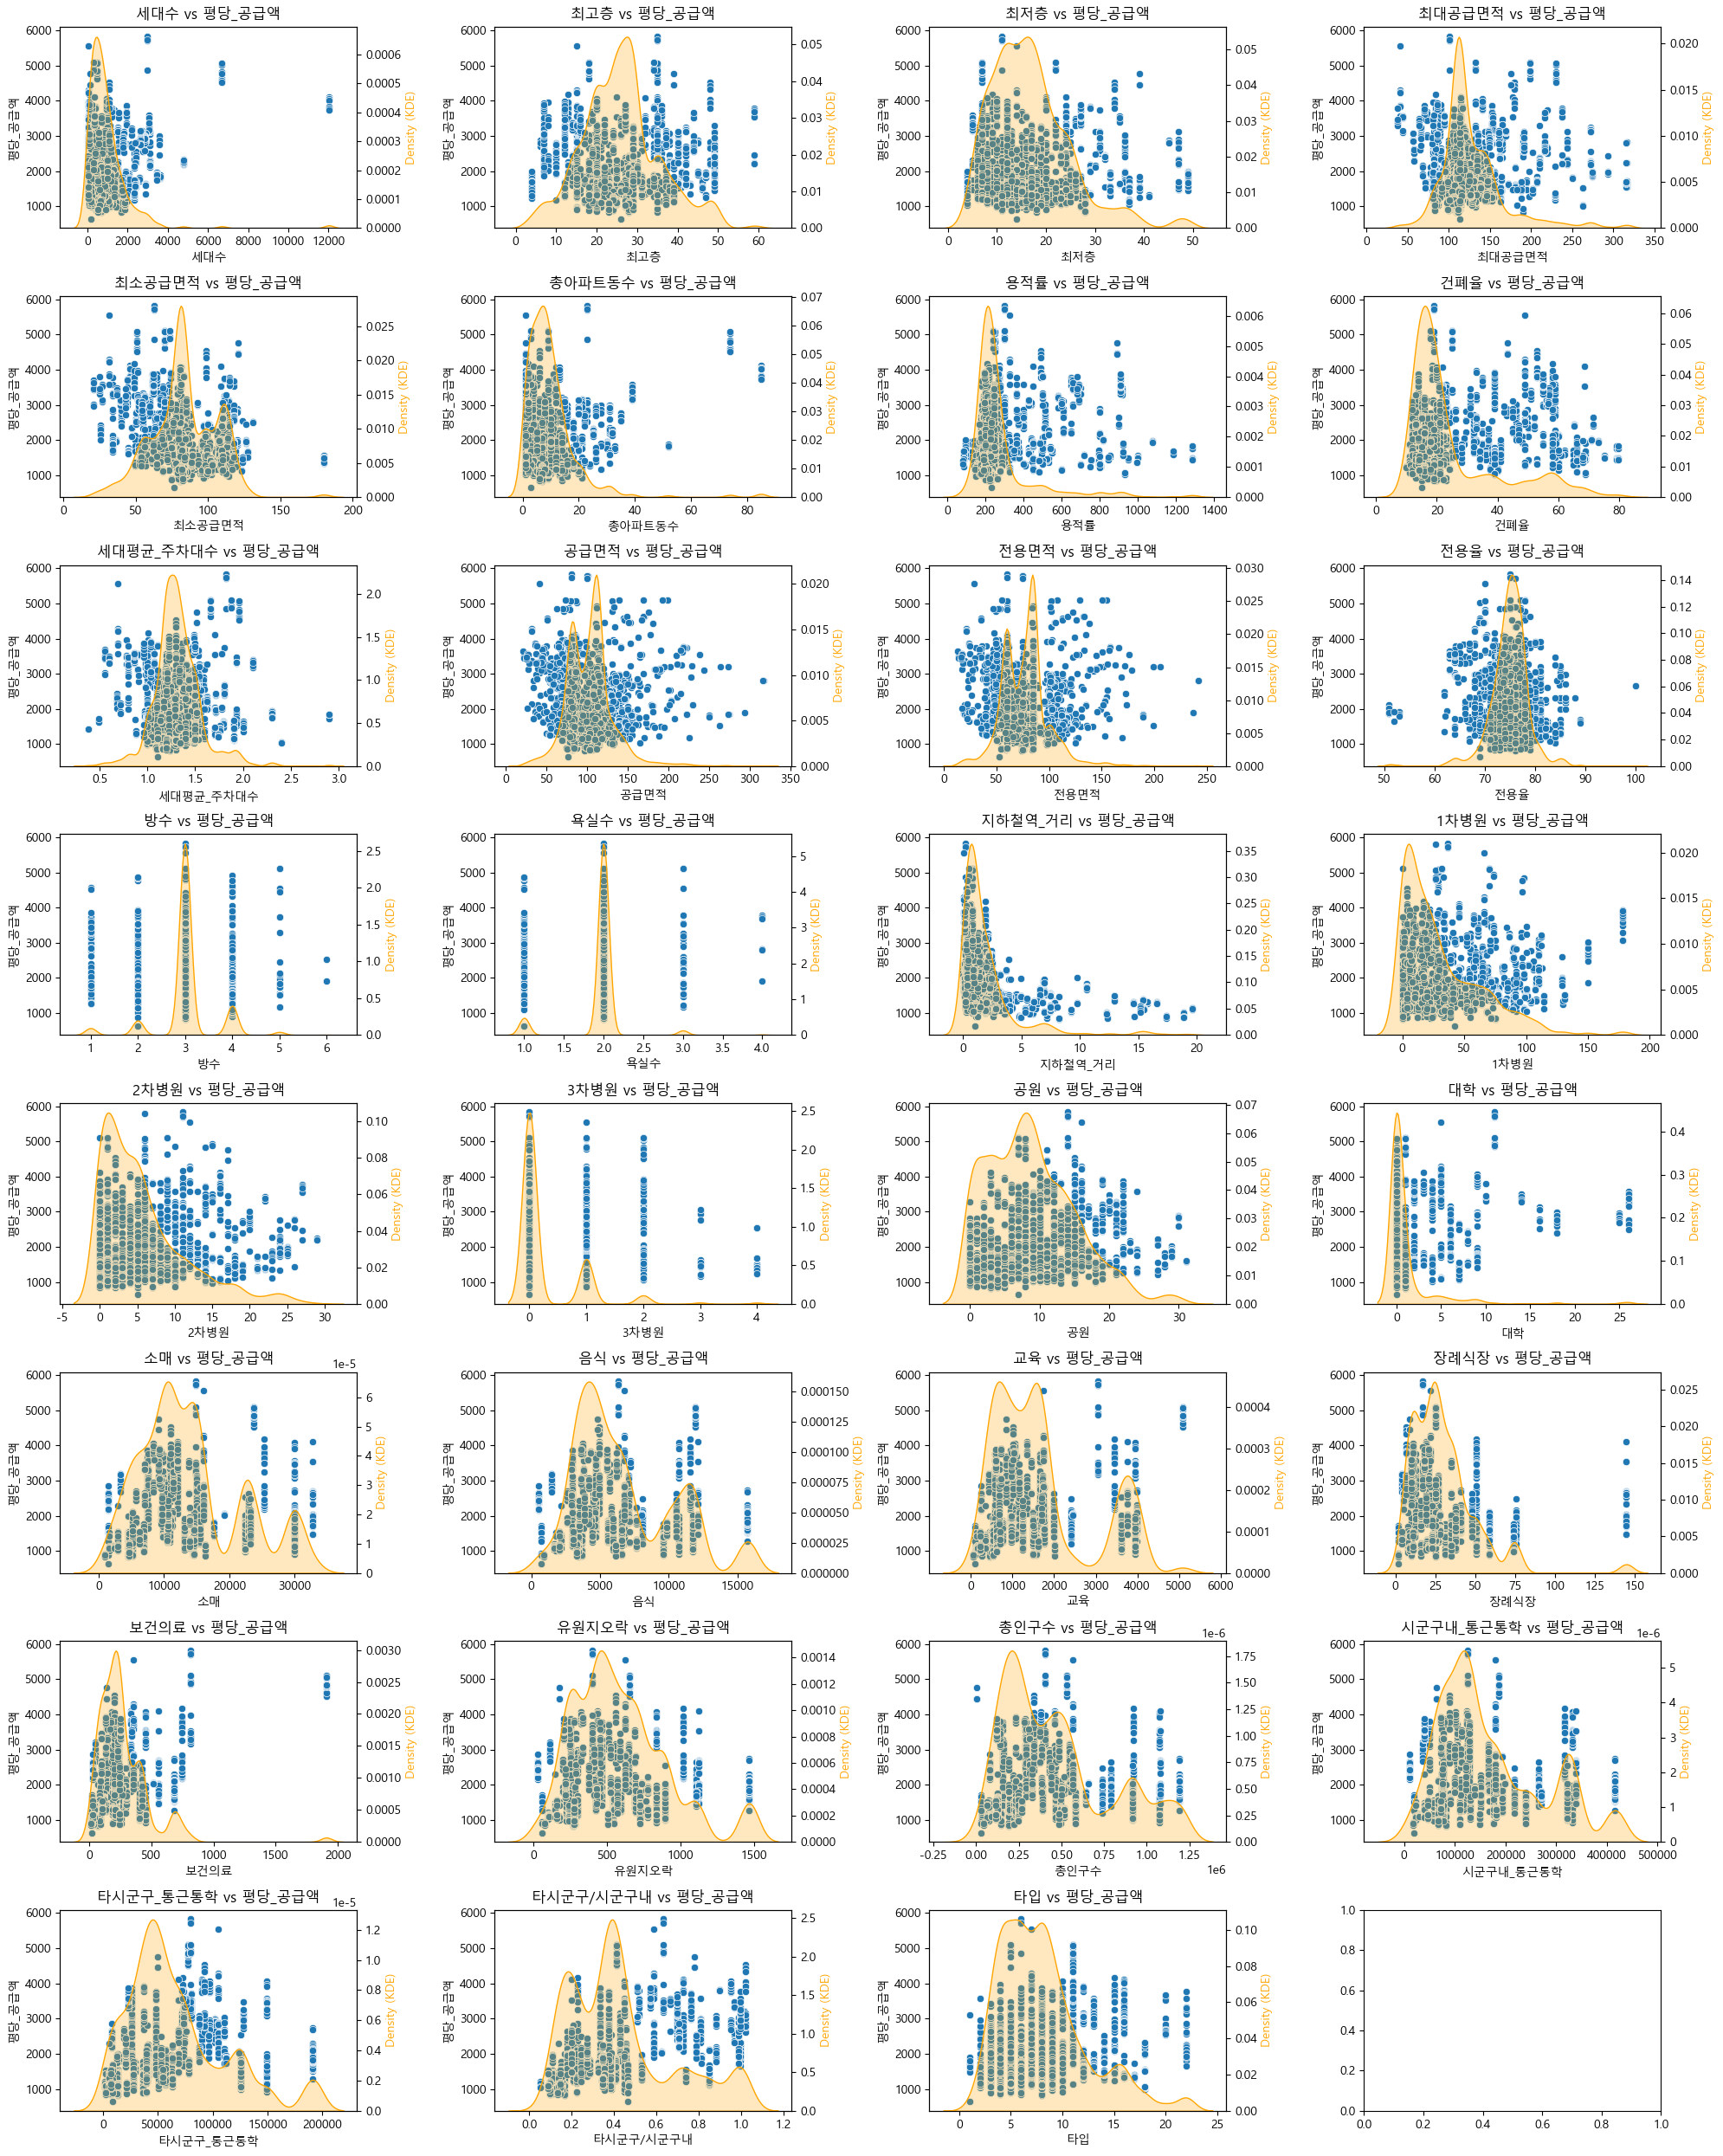

In [83]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 25))

for i, col in enumerate(df_encoded[con_list].columns):  
    row_idx = i // 4
    col_idx = i % 4
    ax = axes[row_idx, col_idx]
    
    sns.scatterplot(x=df_encoded[col], y=df_encoded[y_val_col[1]], ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel('평당_공급액')
    ax.set_title(f'{col} vs 평당_공급액')
    
    # Twin the axes for two different y-axes on the same plot
    ax2 = ax.twinx()
    sns.kdeplot(df_encoded[col], shade=True, ax=ax2, color='orange')
    ax2.set_ylabel('Density (KDE)', color='orange')
    
plt.tight_layout()
plt.show()

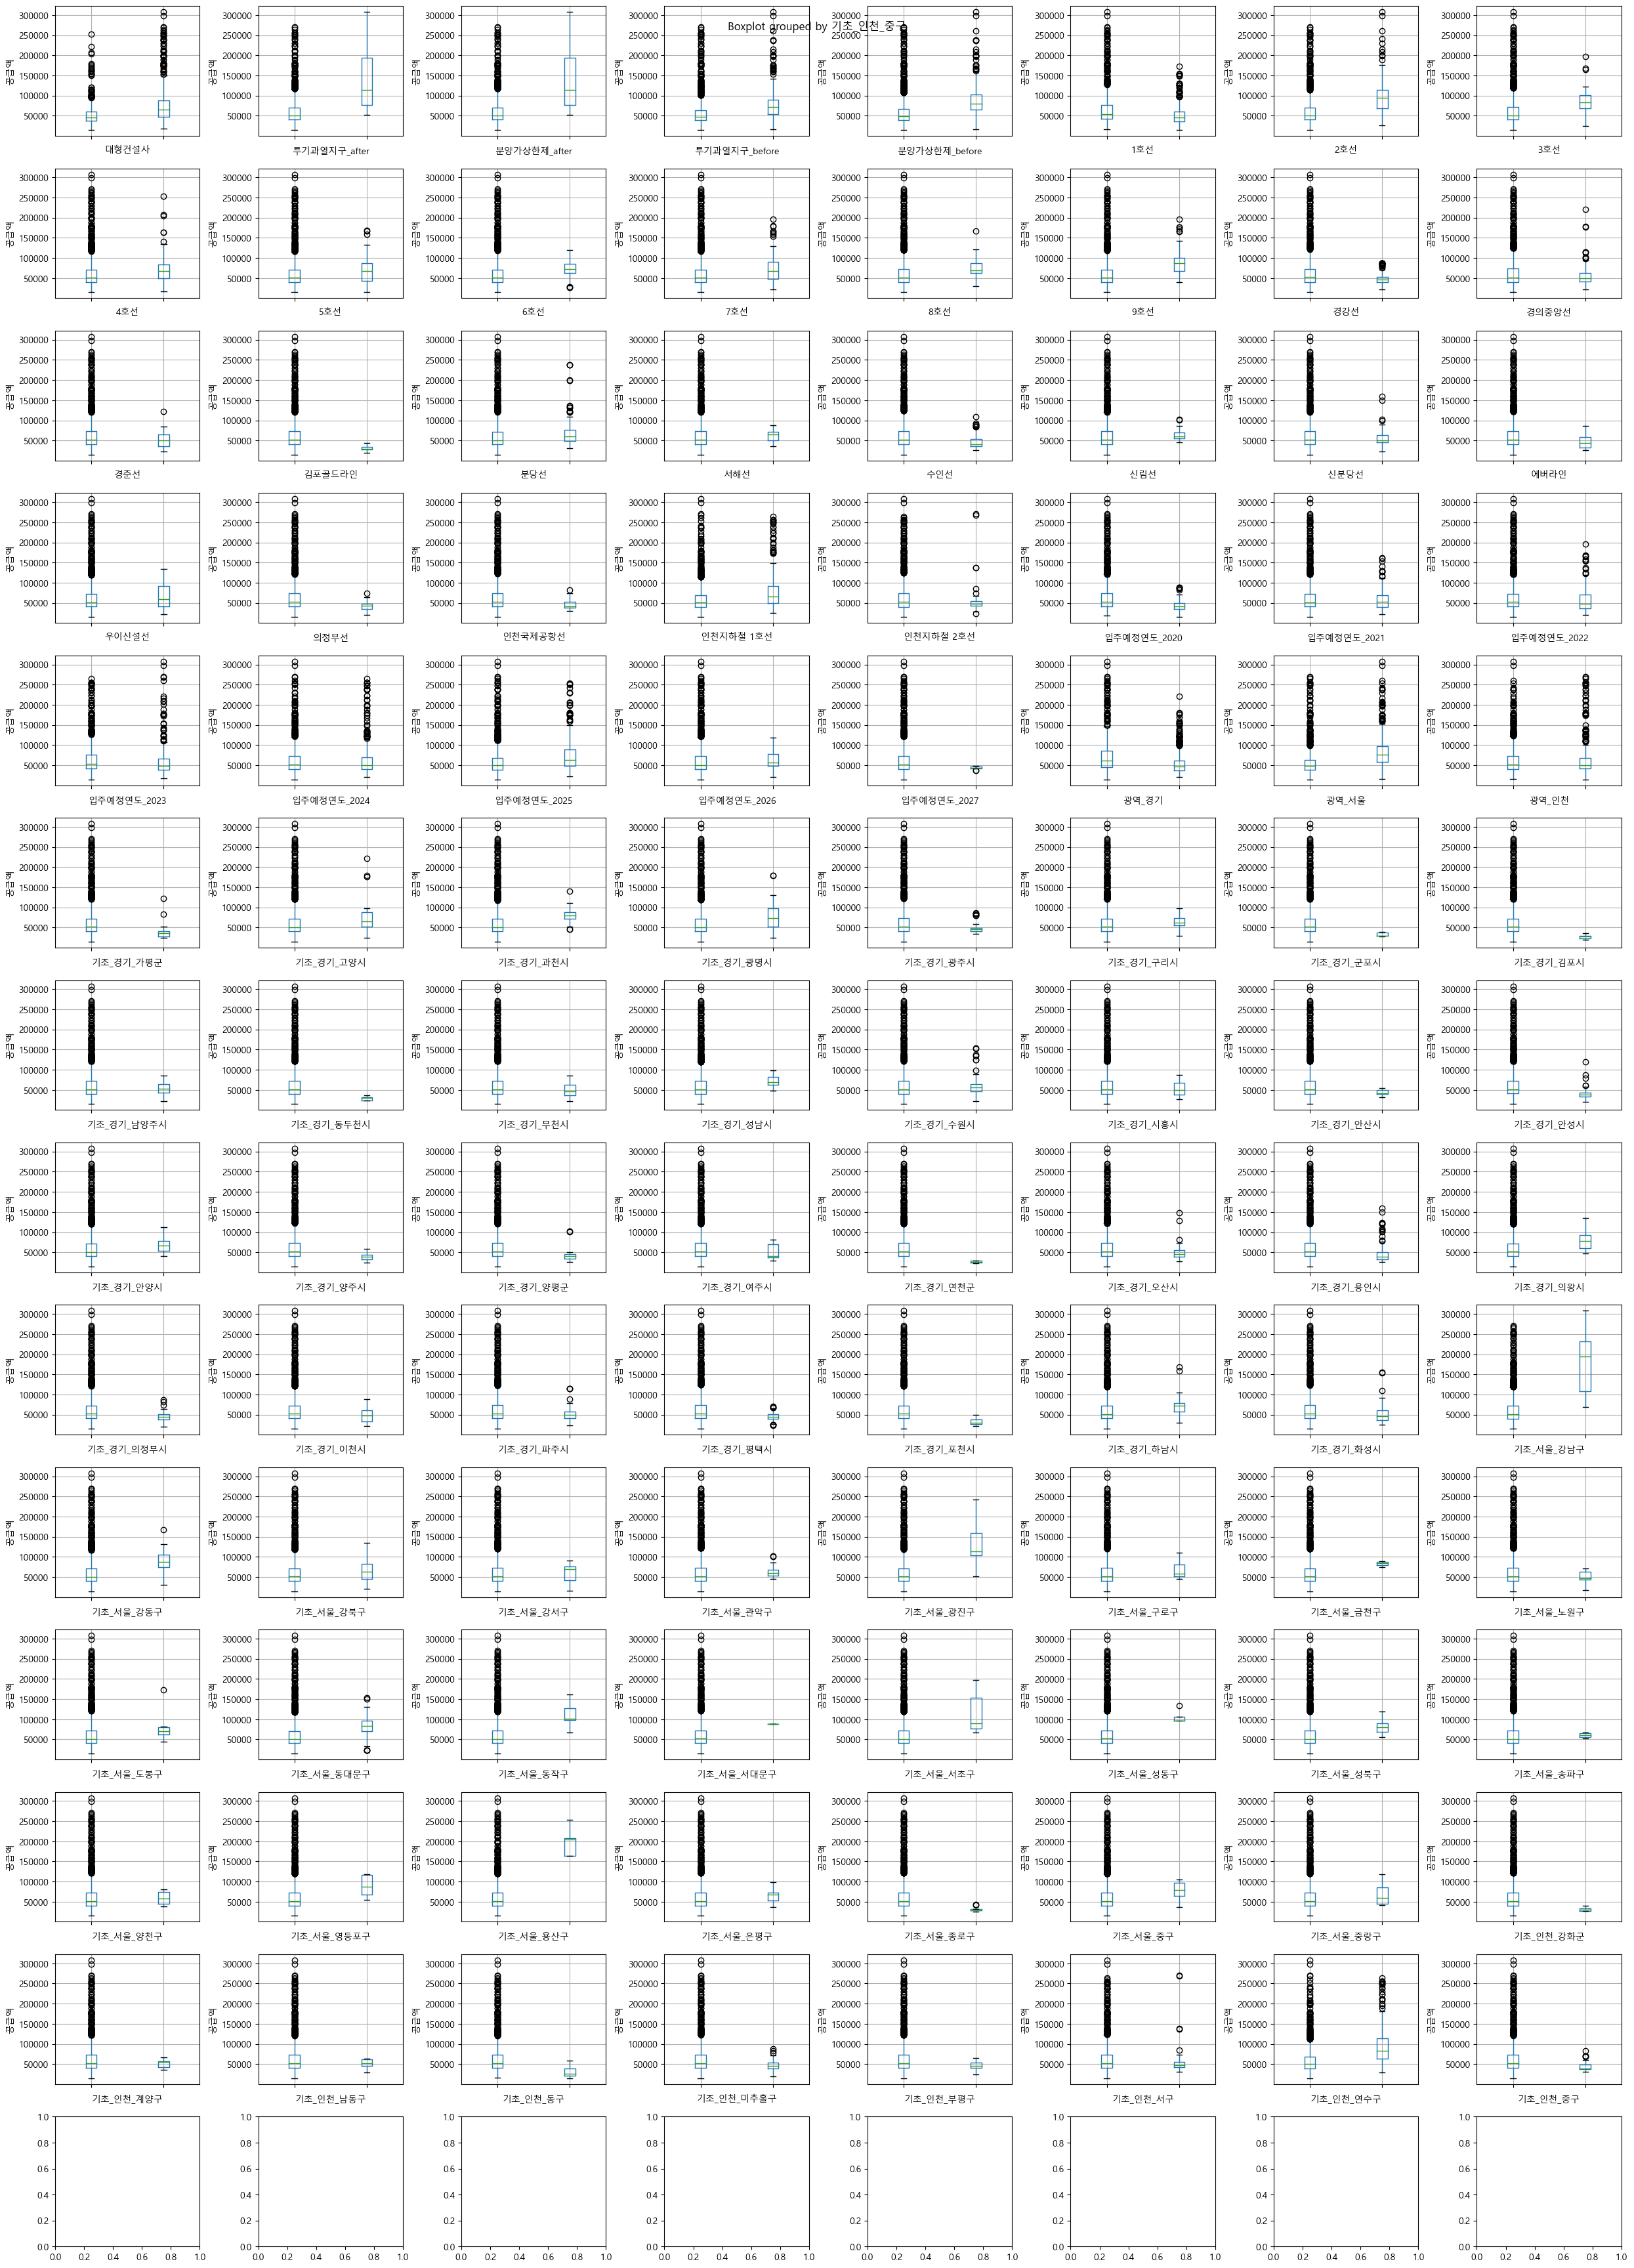

In [84]:
fig, axes = plt.subplots(nrows=13, ncols=8, figsize=(25, 35))

for i, col in enumerate(df_encoded[one_hot_encoded_columns].columns):  # 공급액 컬럼은 제외
    row_idx = i // 8
    col_idx = i % 8
    ax = axes[row_idx, col_idx]
    df_encoded.boxplot(column=y_val_col[0], by=col, ax=ax)
    ax.set_title('')
    ax.set_xlabel(col)
    ax.set_ylabel('공급액')
    ax.set_xticklabels([])

plt.tight_layout()
plt.show()

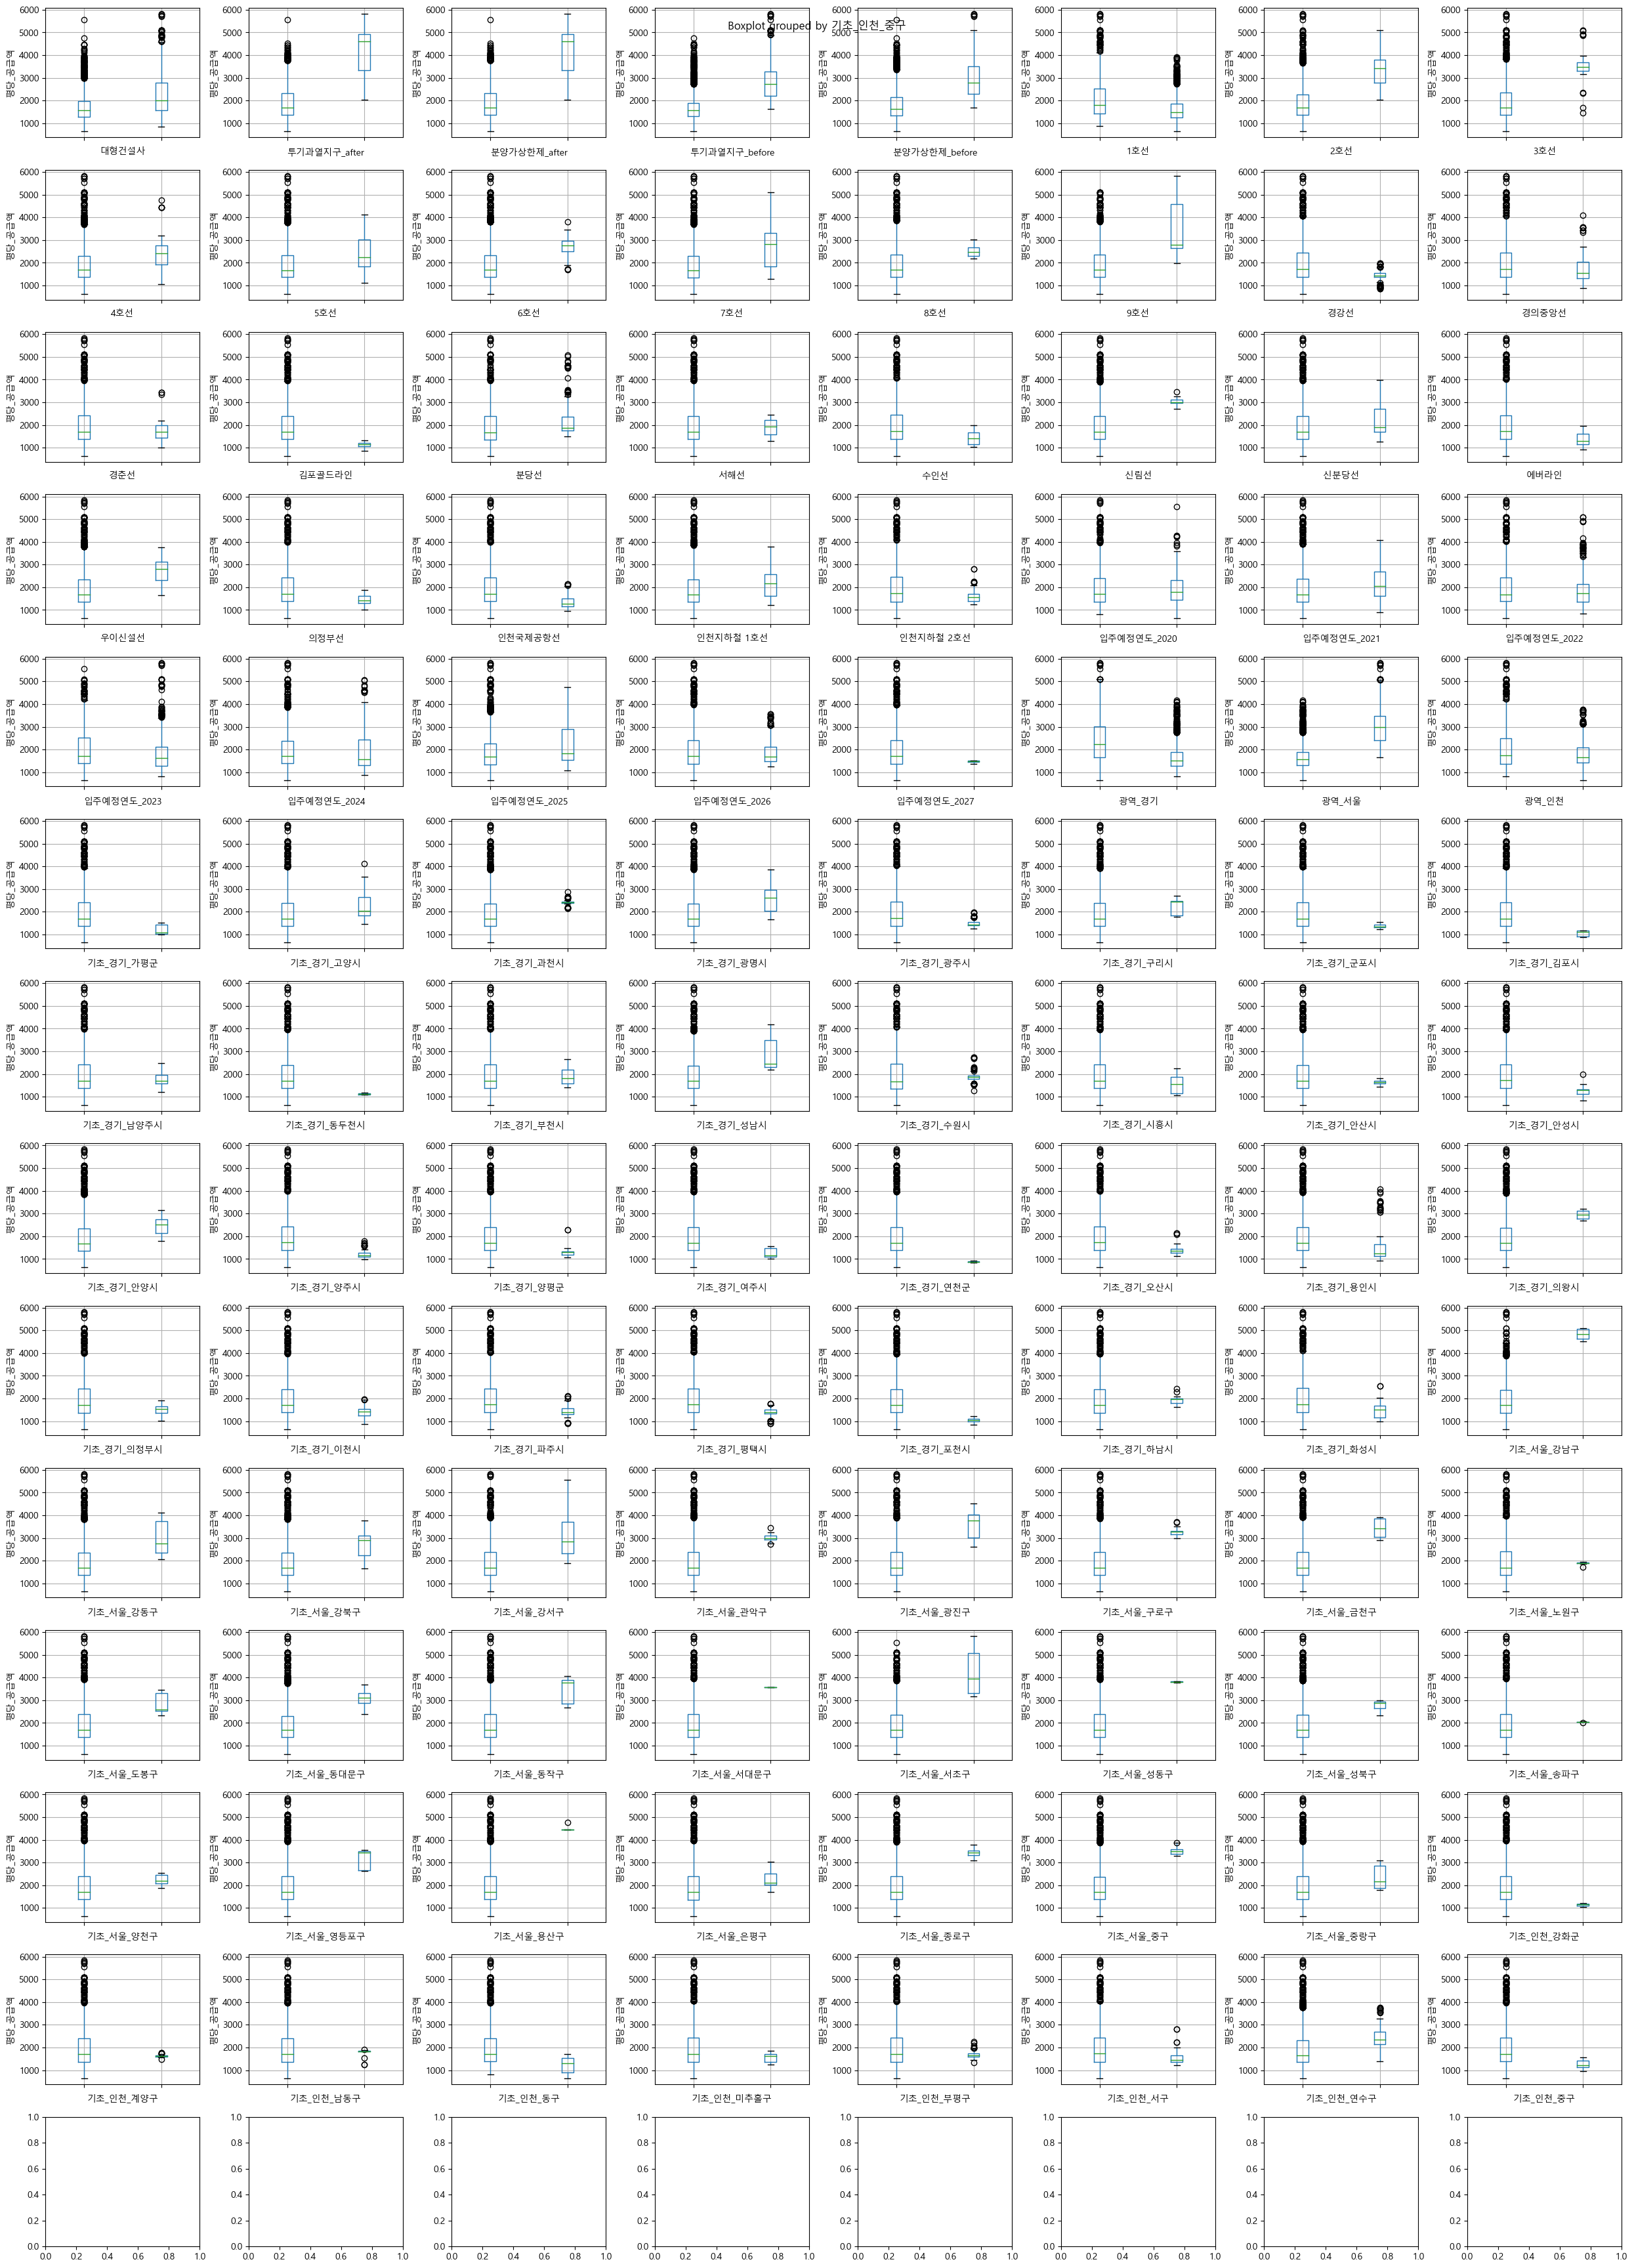

In [85]:
fig, axes = plt.subplots(nrows=13, ncols=8, figsize=(25, 35))

for i, col in enumerate(df_encoded[one_hot_encoded_columns].columns):  # 공급액 컬럼은 제외
    row_idx = i // 8
    col_idx = i % 8
    ax = axes[row_idx, col_idx]
    df_encoded.boxplot(column=y_val_col[1], by=col, ax=ax)
    ax.set_title('')
    ax.set_xlabel(col)
    ax.set_ylabel('평당_공급액')
    ax.set_xticklabels([])

plt.tight_layout()
plt.show()

In [86]:
column_sums = df_encoded[one_hot_encoded_columns].sum()

columns_with_sum_above_100 = column_sums[column_sums >= 100].index.tolist()

print("Columns with sum above 100:", columns_with_sum_above_100)

Columns with sum above 100: ['대형건설사', '투기과열지구_before', '분양가상한제_before', '1호선', '4호선', '5호선', '7호선', '경강선', '경의중앙선', '분당선', '수인선', '에버라인', '인천지하철 1호선', '인천지하철 2호선', '입주예정연도_2021', '입주예정연도_2022', '입주예정연도_2023', '입주예정연도_2024', '입주예정연도_2025', '입주예정연도_2026', '광역_경기', '광역_서울', '광역_인천', '기초_경기_수원시', '기초_경기_파주시', '기초_경기_평택시', '기초_경기_화성시', '기초_인천_서구', '기초_인천_연수구']


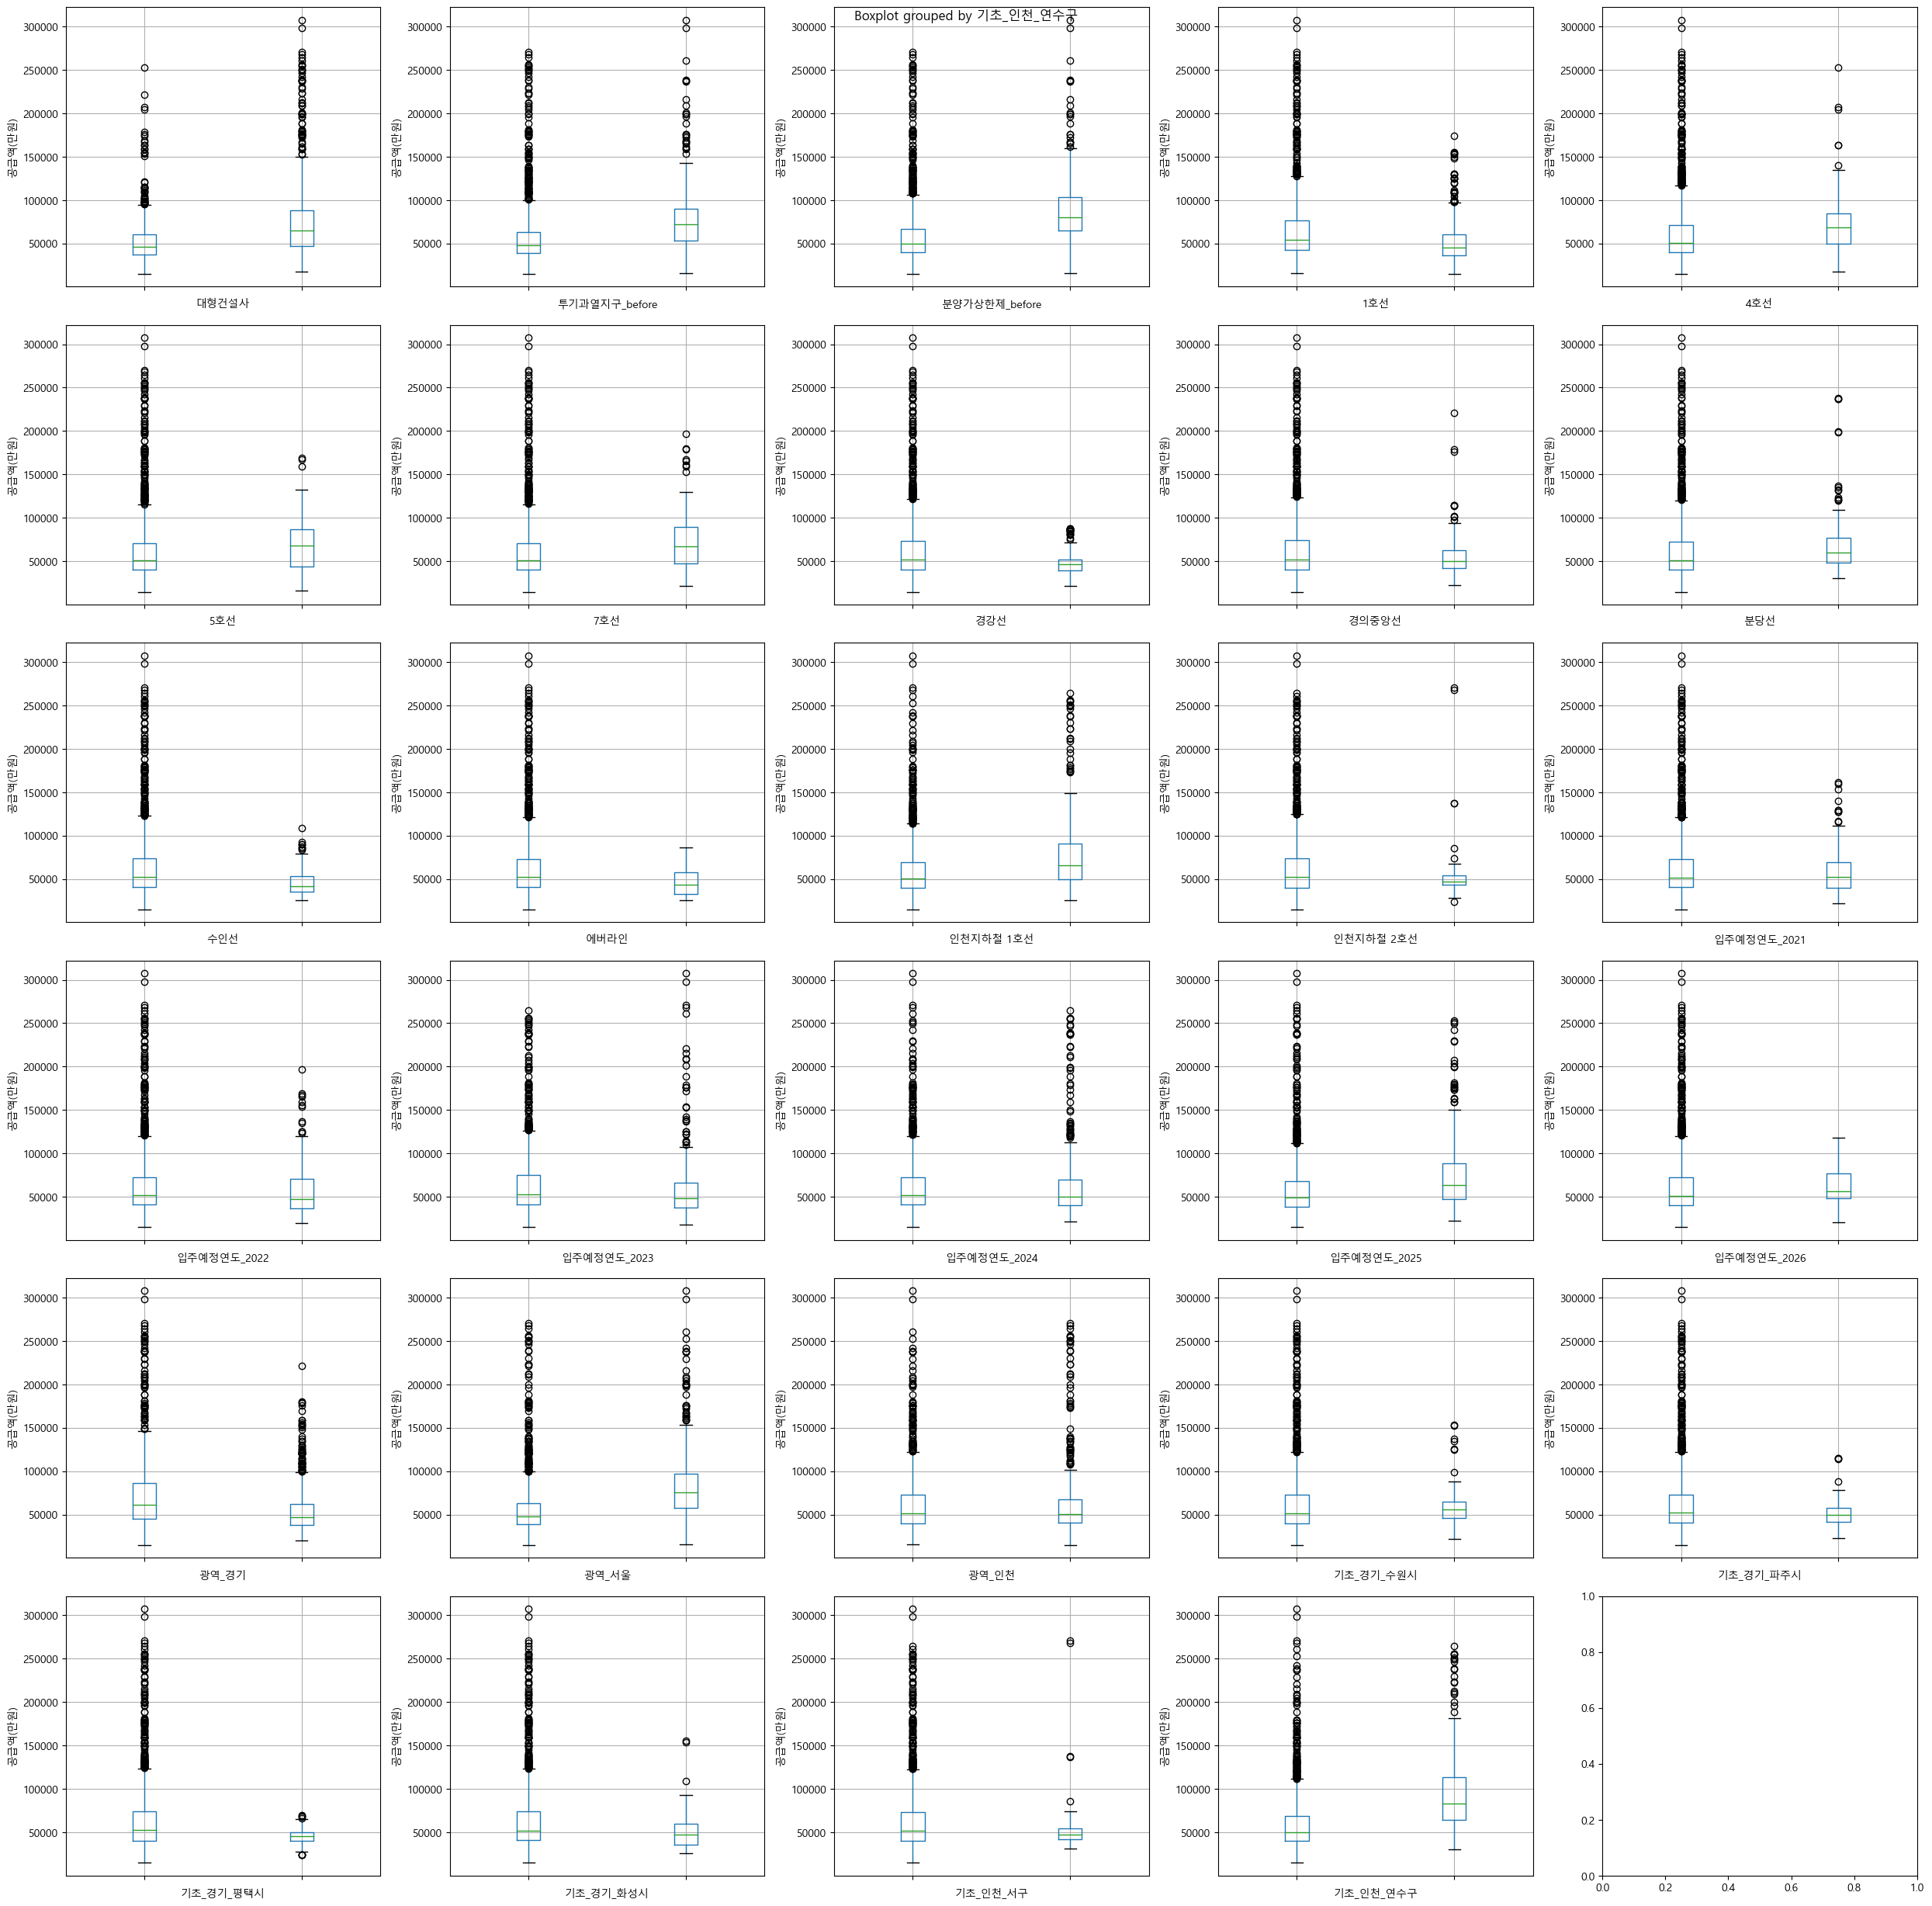

In [87]:
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(25, 25))

for i, col in enumerate(df_encoded[columns_with_sum_above_100].columns): 
    row_idx = i // 5
    col_idx = i % 5
    ax = axes[row_idx, col_idx]
    df_encoded.boxplot(column=y_val_col[0], by=col, ax=ax)
    ax.set_title('')
    ax.set_xlabel(col)
    ax.set_ylabel(y_val_col[0])
    ax.set_xticklabels([])

plt.tight_layout()
plt.show()

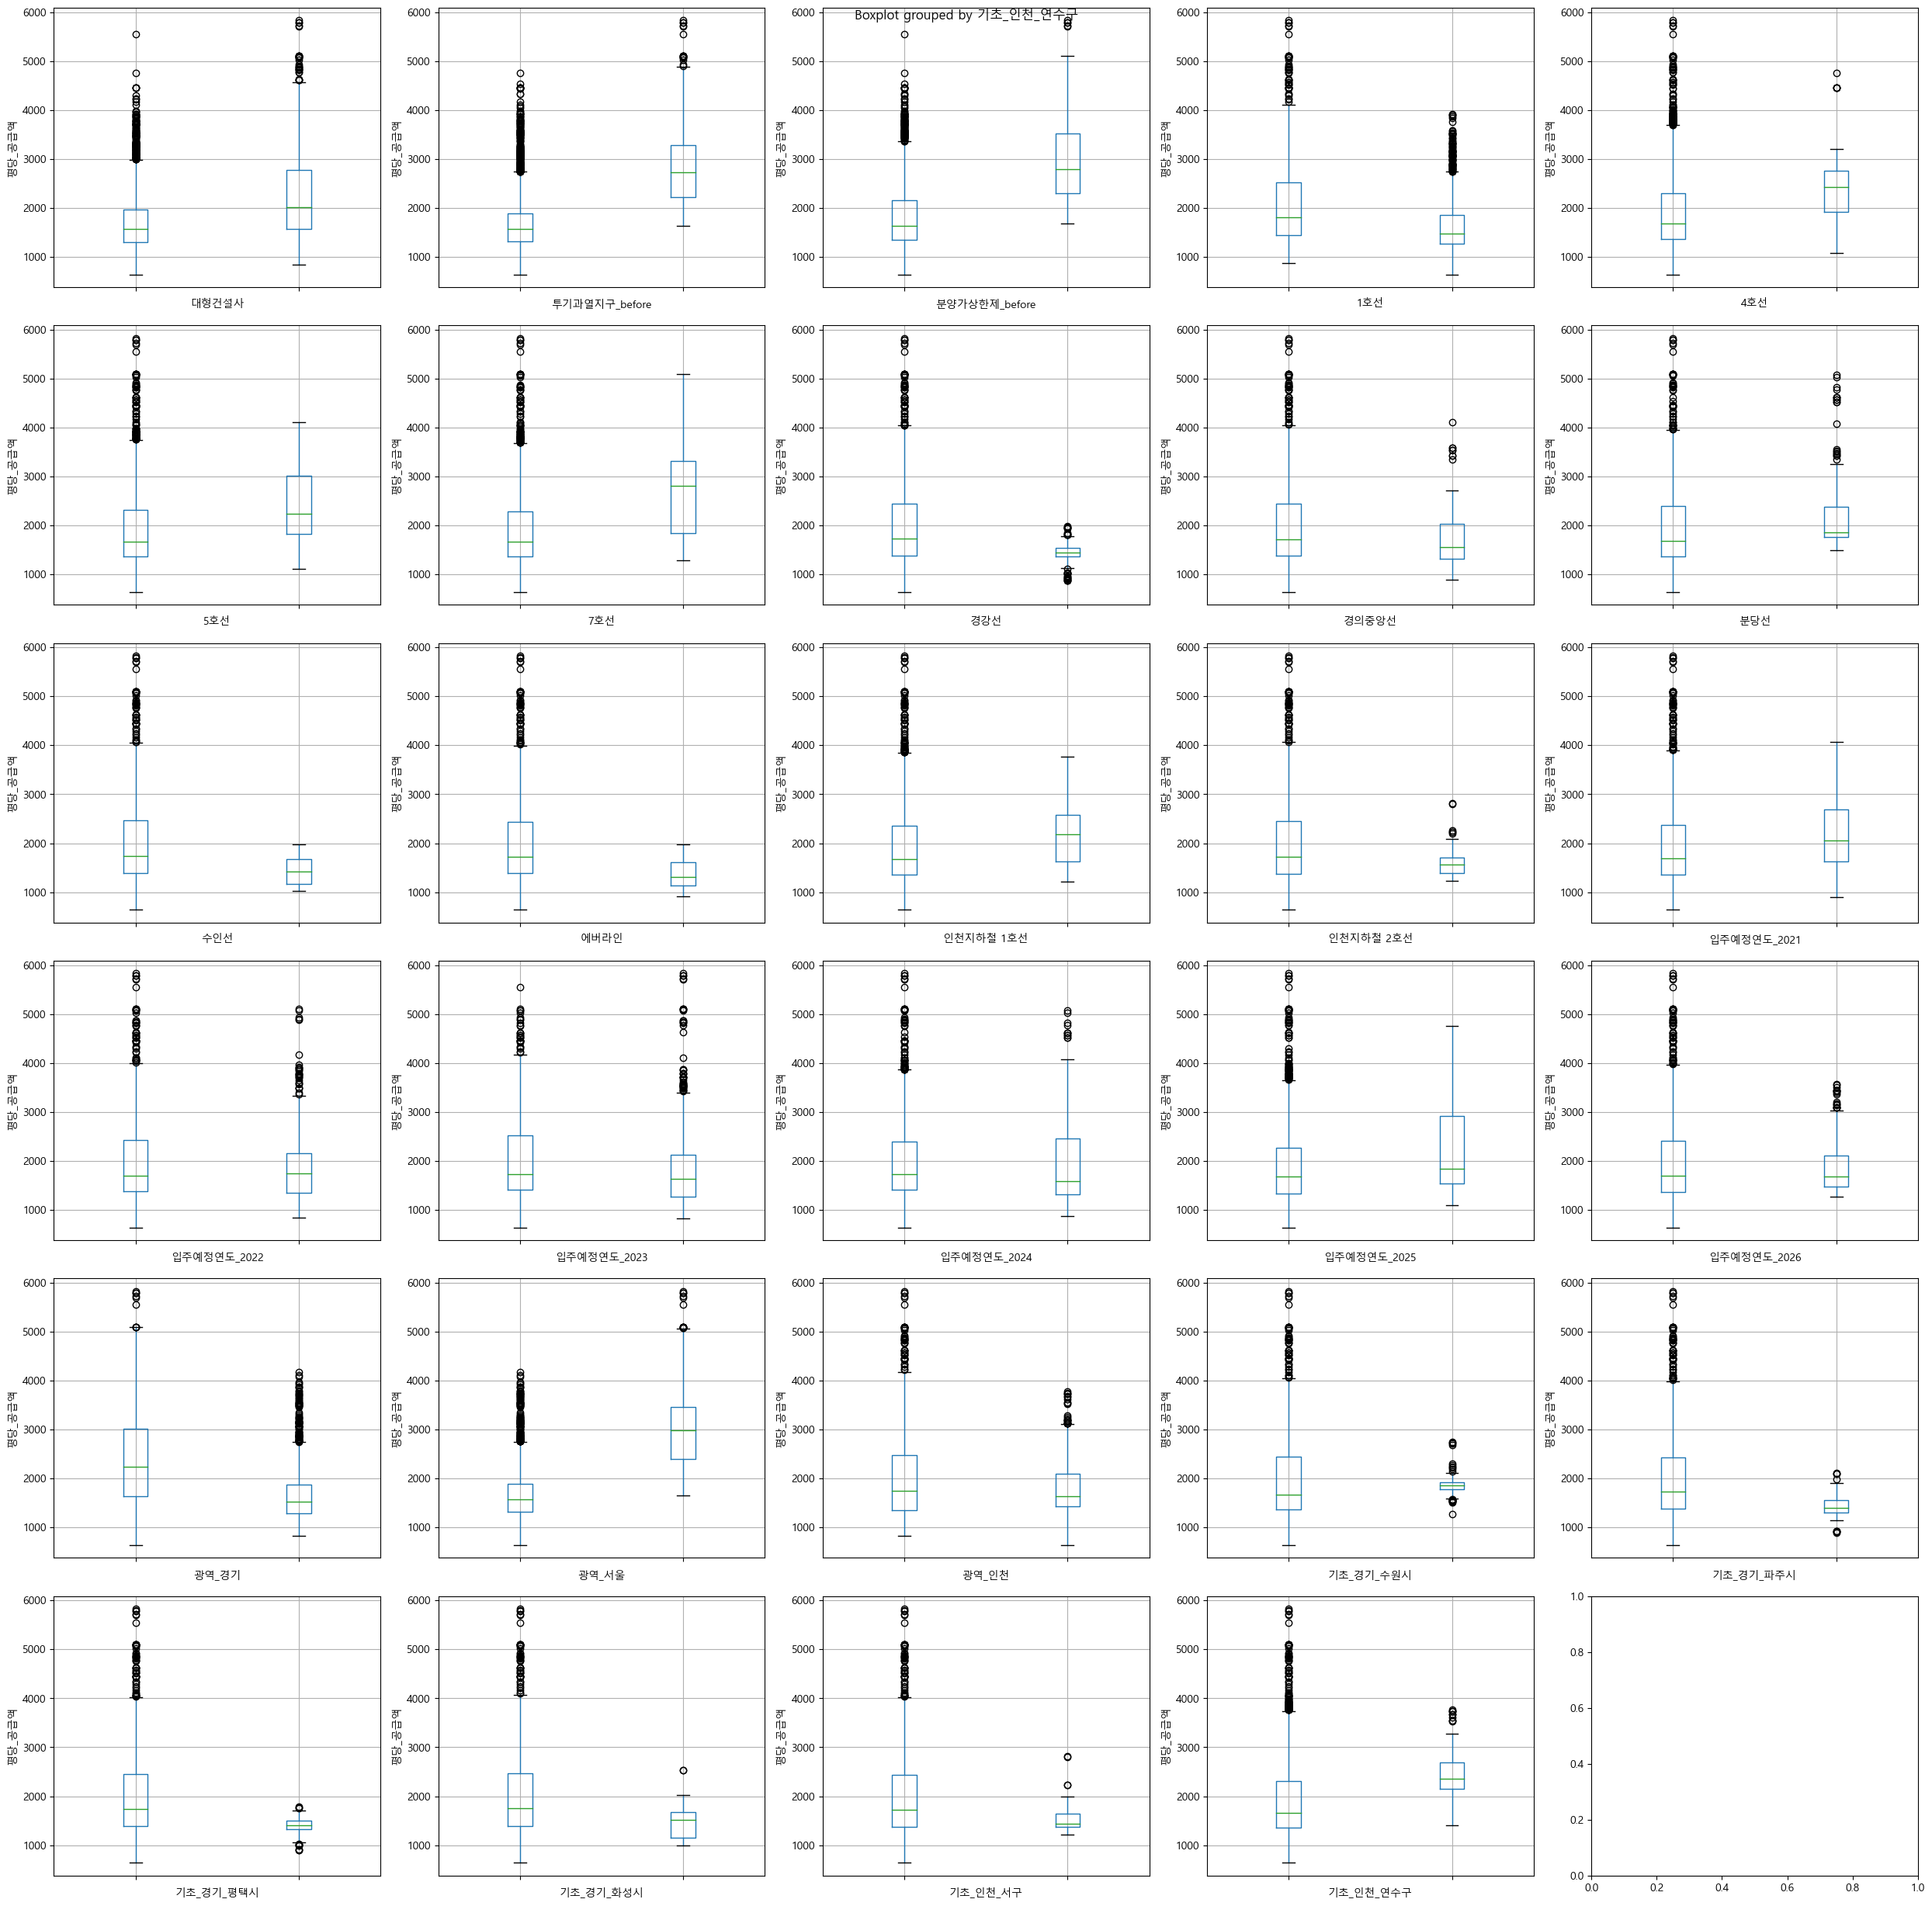

In [88]:
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(25, 25))

for i, col in enumerate(df_encoded[columns_with_sum_above_100].columns):  # 공급액 컬럼은 제외
    row_idx = i // 5
    col_idx = i % 5
    ax = axes[row_idx, col_idx]
    df_encoded.boxplot(column=y_val_col[1], by=col, ax=ax)
    ax.set_title('')
    ax.set_xlabel(col)
    ax.set_ylabel(y_val_col[1])
    ax.set_xticklabels([])

plt.tight_layout()
plt.show()

### 아웃라이어를 제외하고 시각화

In [96]:
# Define a function to remove outliers using IQR method
def remove_outliers(df, column, threshold=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

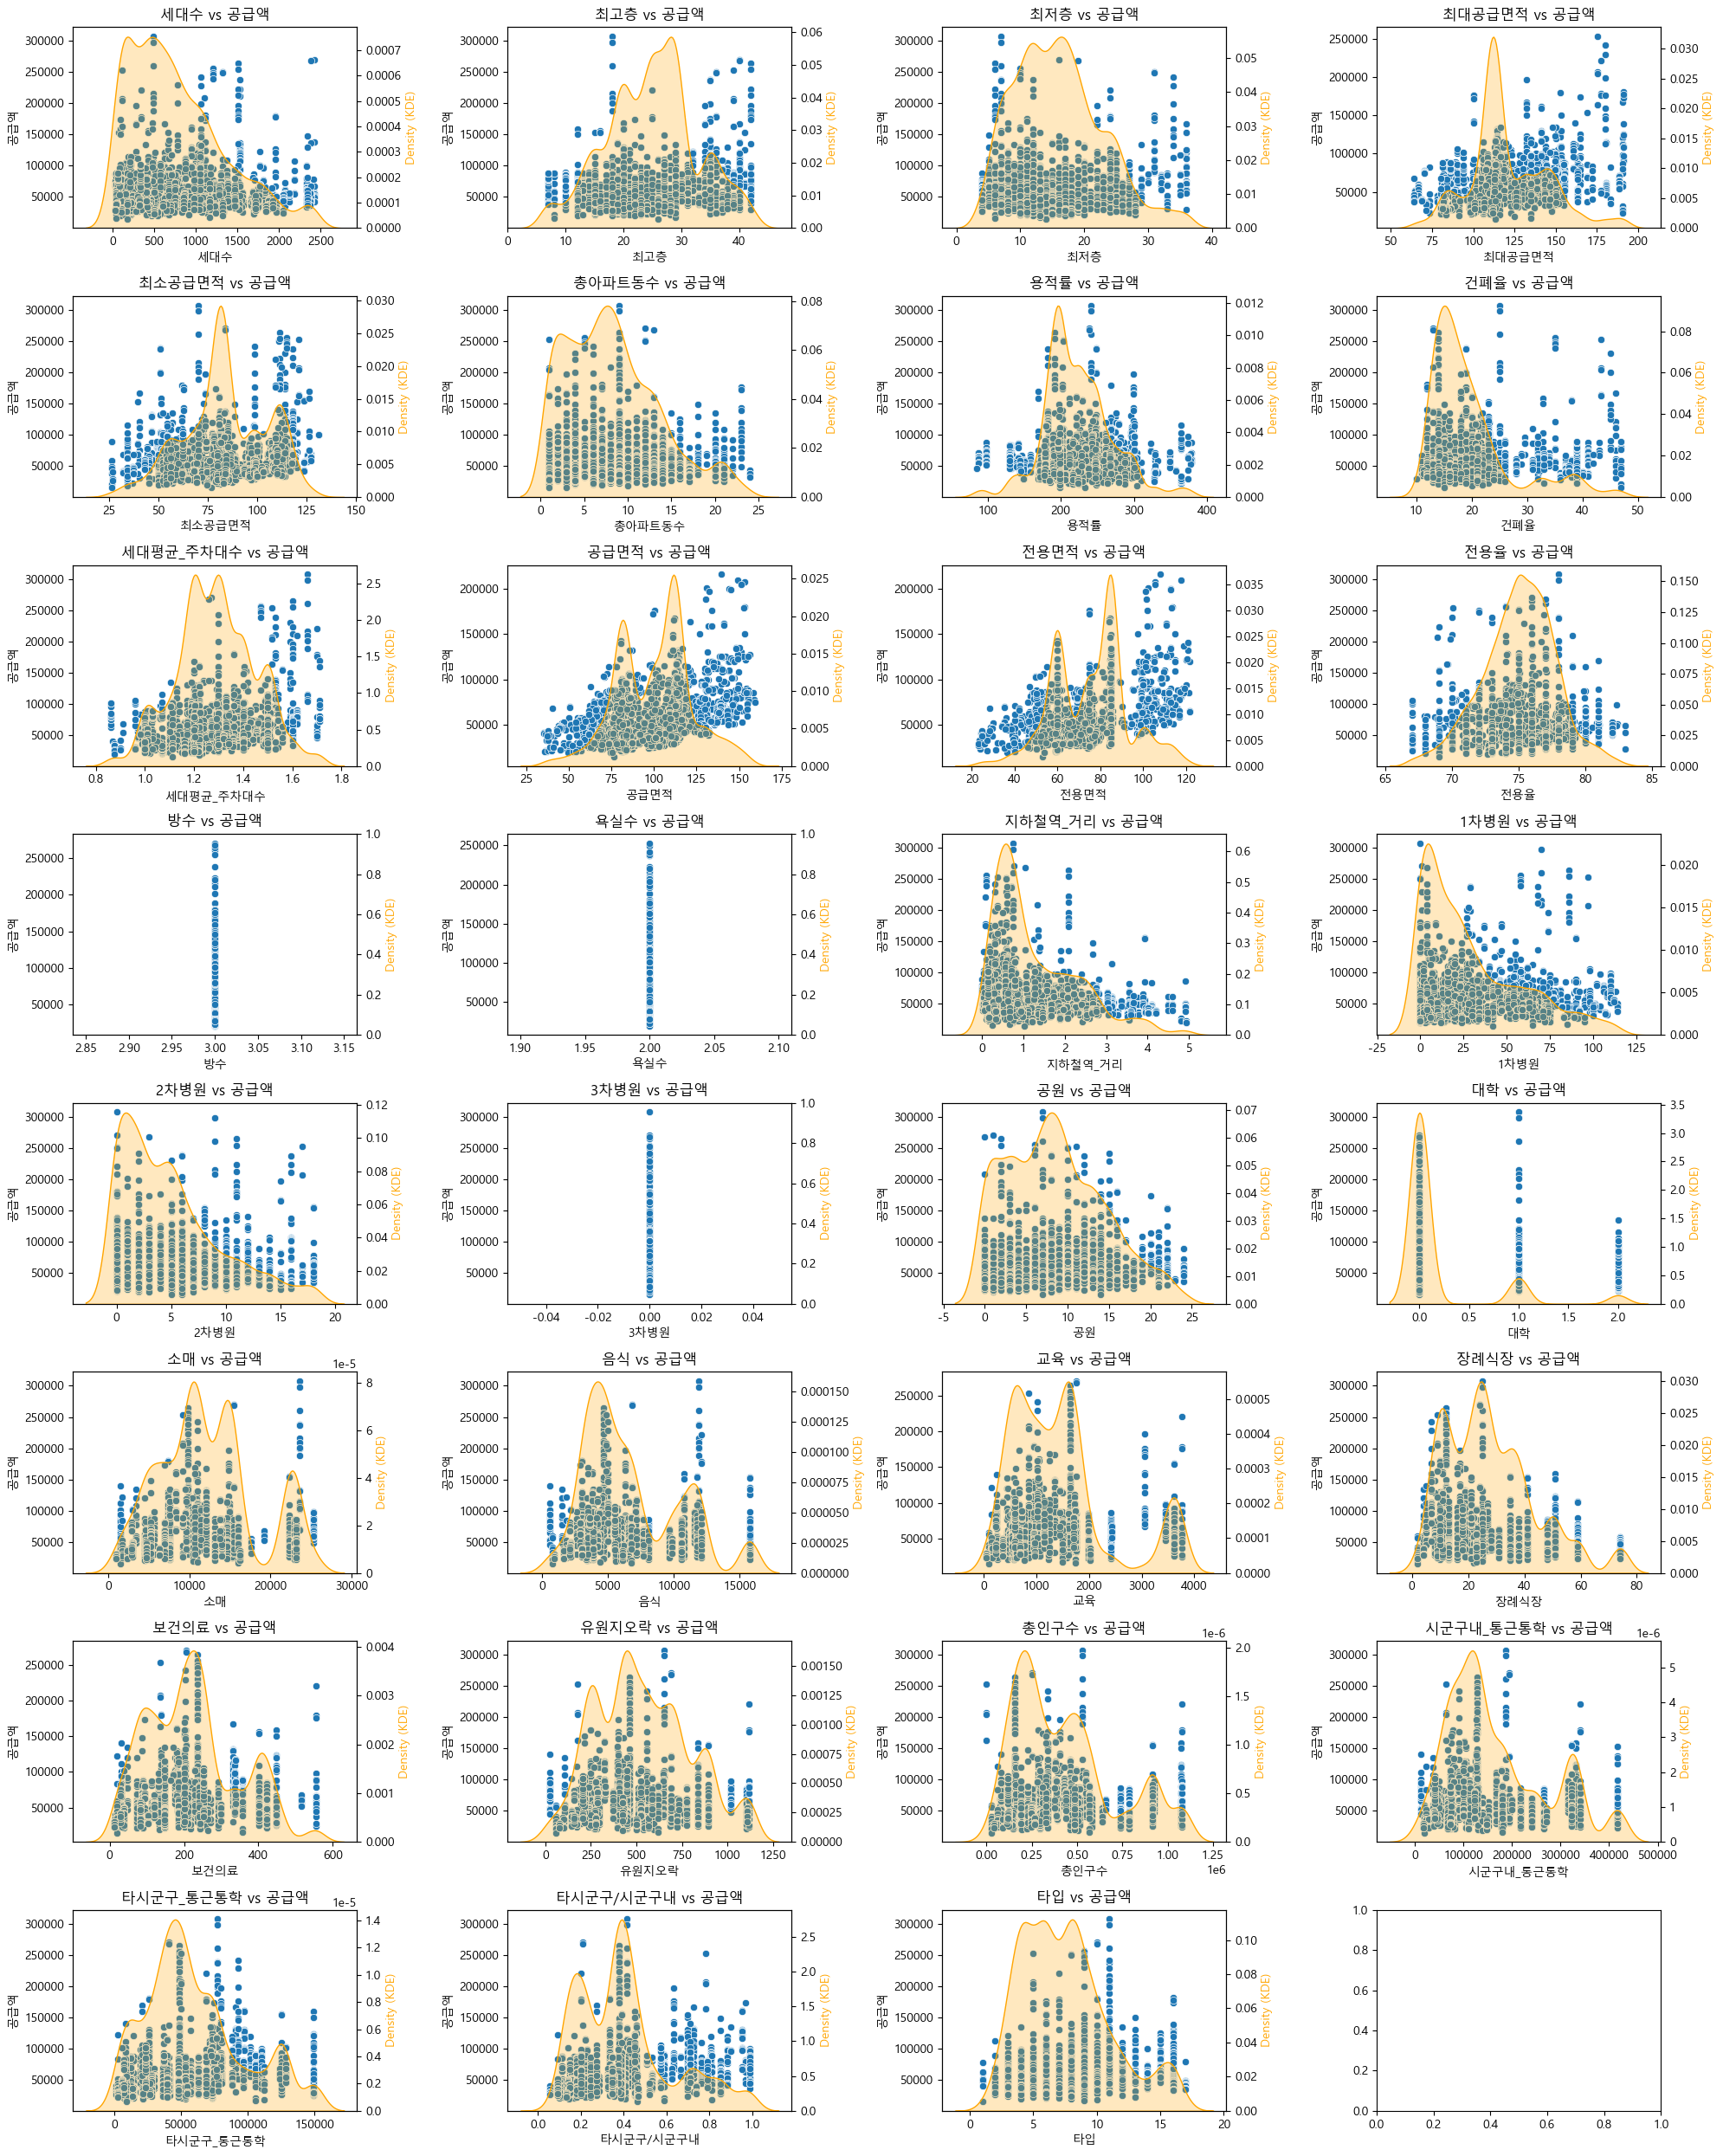

In [100]:
# Your existing code
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 25))

for i, col in enumerate(df_encoded[con_list].columns):  
    # ... (rest of your existing code)
    row_idx = i // 4
    col_idx = i % 4
    ax = axes[row_idx, col_idx]
    
    # Remove outliers from the column before plotting
    df_no_outliers = remove_outliers(df_encoded, col)
    
    sns.scatterplot(x=df_no_outliers[col], y=df_no_outliers[y_val_col[0]], ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel(y_val_col[0])
    ax.set_title(f'{col} vs {y_val_col[0]}')
    
    ax2 = ax.twinx()
    sns.kdeplot(df_no_outliers[col], shade=True, ax=ax2, color='orange')
    ax2.set_ylabel('Density (KDE)', color='orange')
    
plt.tight_layout()
plt.show()

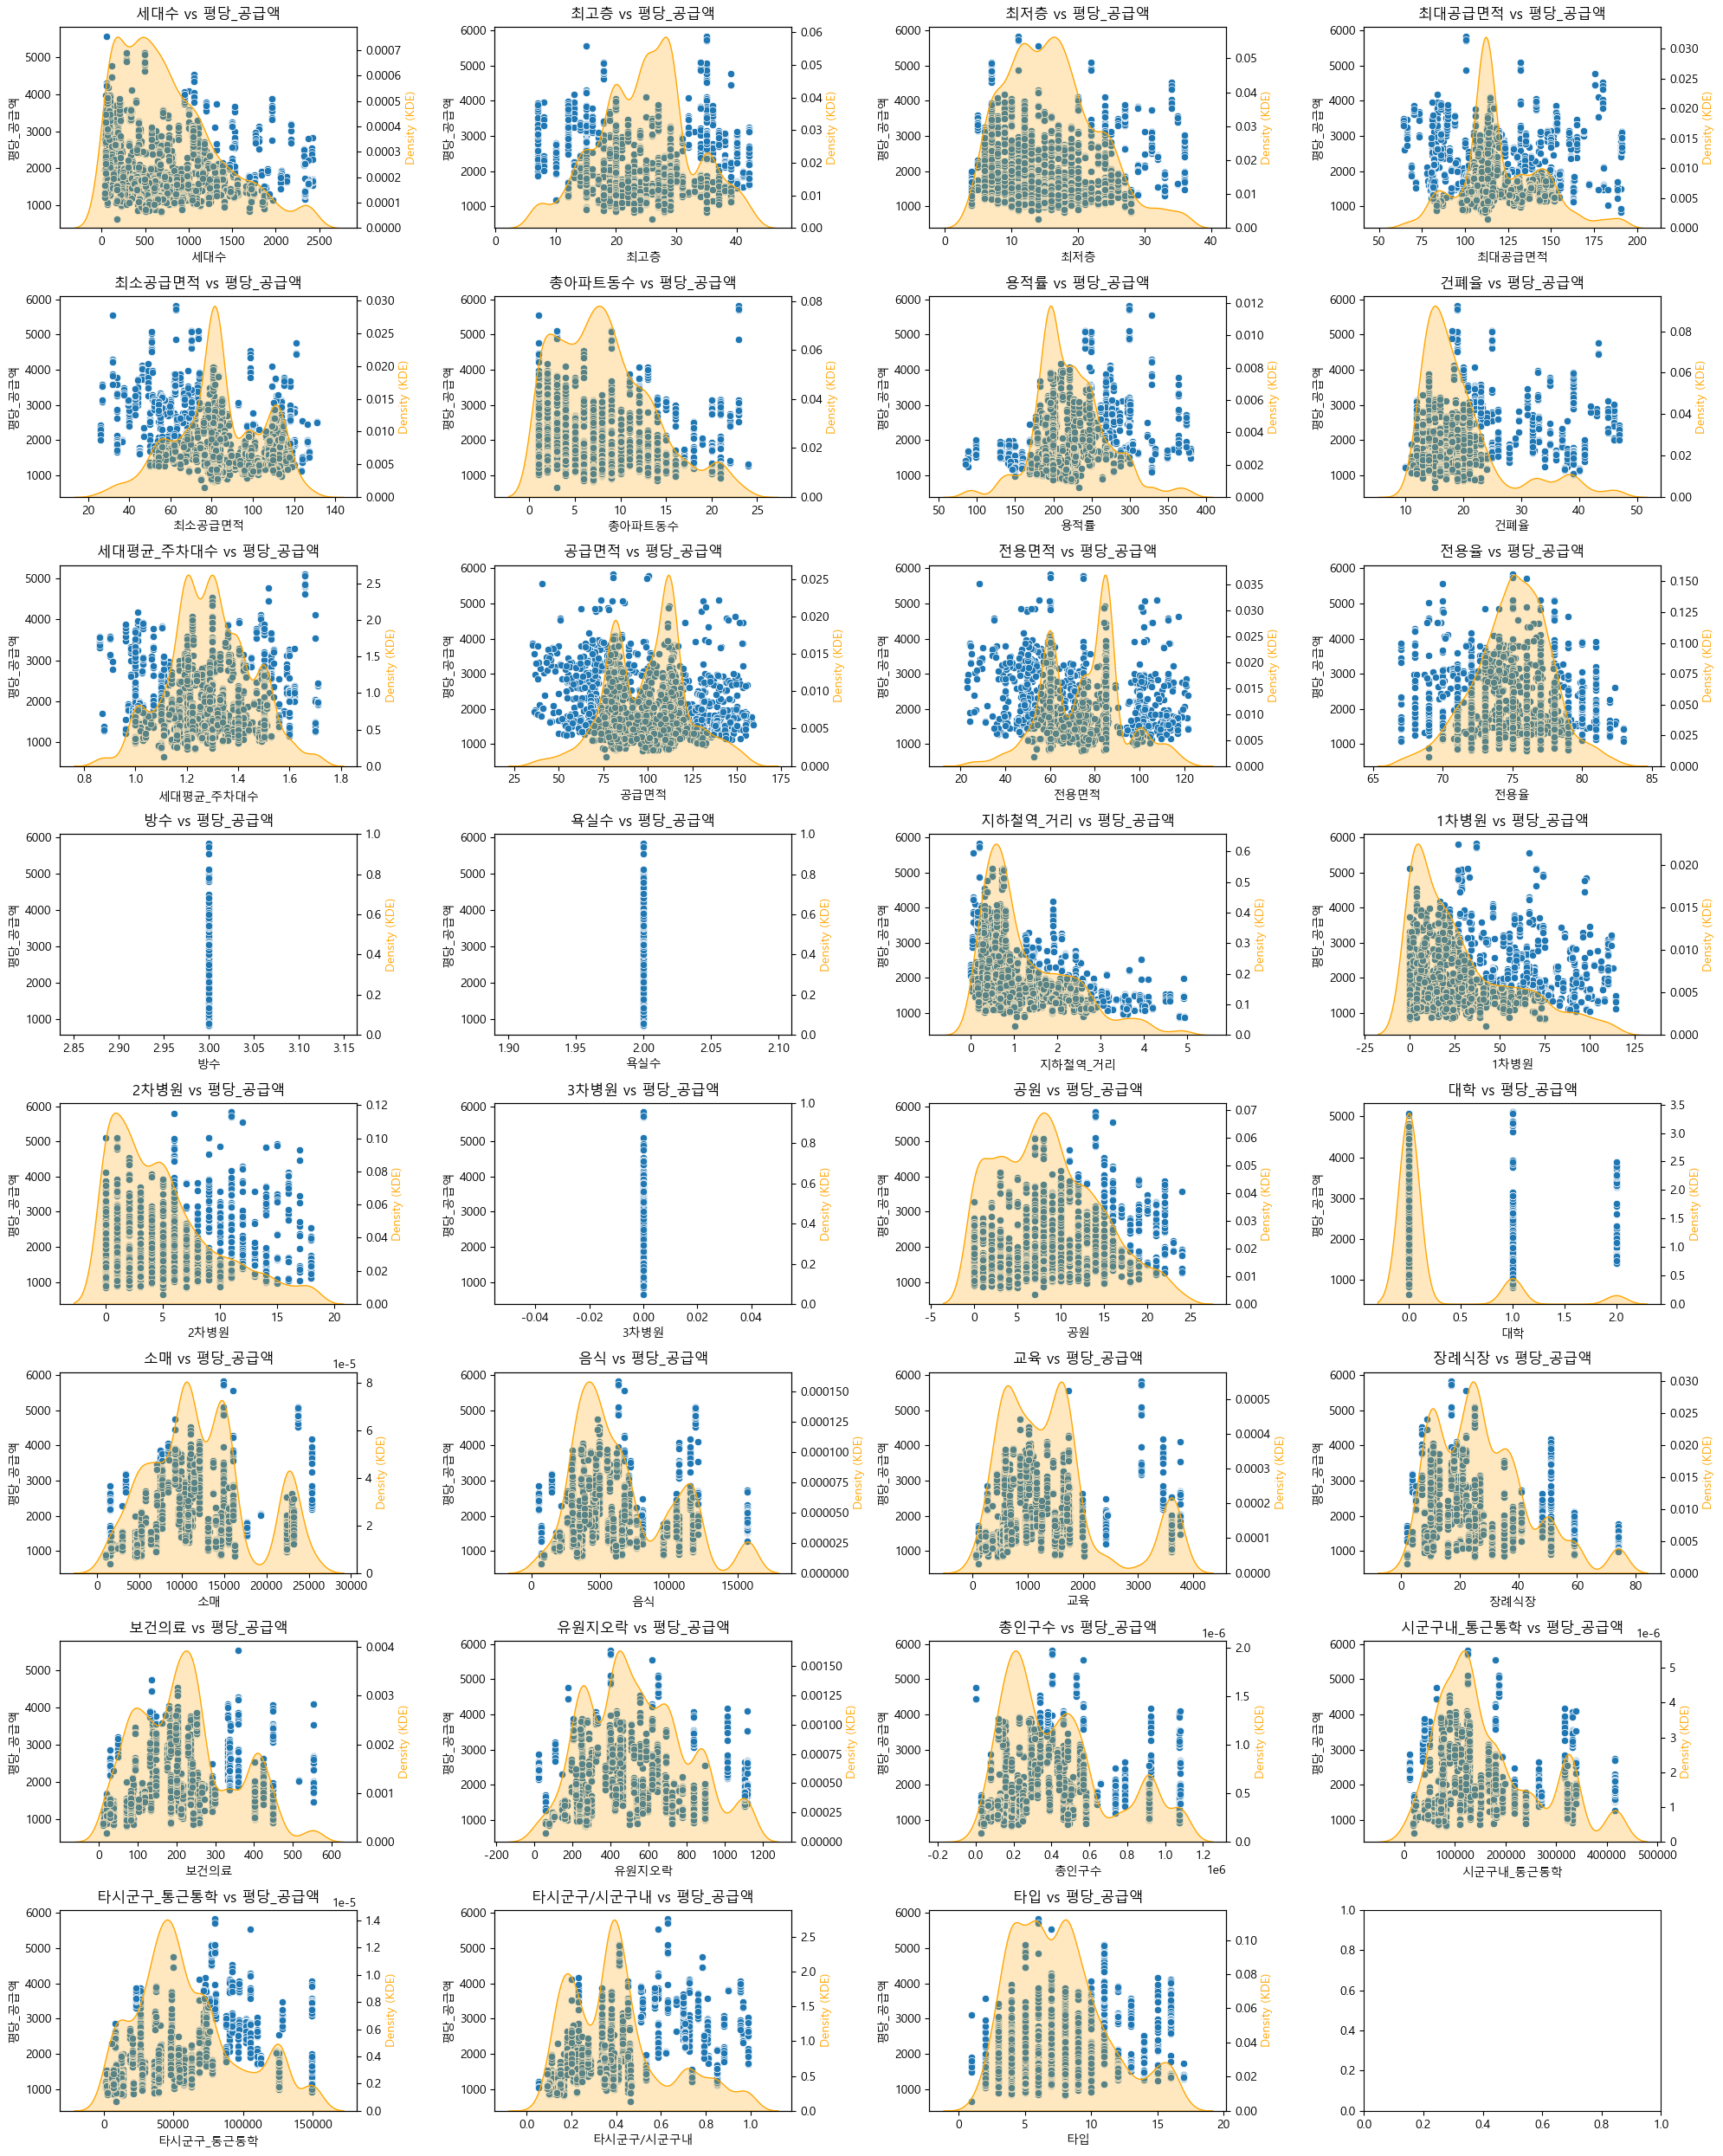

In [101]:
# Your existing code
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 25))

for i, col in enumerate(df_encoded[con_list].columns):  
    # ... (rest of your existing code)
    row_idx = i // 4
    col_idx = i % 4
    ax = axes[row_idx, col_idx]
    
    # Remove outliers from the column before plotting
    df_no_outliers = remove_outliers(df_encoded, col)
    
    sns.scatterplot(x=df_no_outliers[col], y=df_no_outliers[y_val_col[1]], ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel(y_val_col[1])
    ax.set_title(f'{col} vs {y_val_col[1]}')
    
    ax2 = ax.twinx()
    sns.kdeplot(df_no_outliers[col], shade=True, ax=ax2, color='orange')
    ax2.set_ylabel('Density (KDE)', color='orange')
    
plt.tight_layout()
plt.show()

### 모든변수 사용

In [49]:
target_df = df_encoded[y_val_col]

In [50]:
X = df_y_drop2
y = target_df.iloc[:,0]

In [51]:
# 모델들과 모델명 리스트 준비
linear_models = [
    ('Ridge', Ridge(alpha=1.0)),
    ('Lasso', Lasso(alpha=1.0)),
    ('Ordinary Least Squares', LinearRegression())
]

In [52]:
def results_predictions(results, y_test):
    # 결과 저장용 리스트 초기화
    performance_metrics = []

    # 각 선형 모델의 예측 값에 대한 성능 메트릭 계산
    for result in results:
        model_name = result['model']
        y_pred = result['predictions']
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        performance_metrics.append({
            'model': model_name,
            'RMSE': rmse,
            'MAE': mae,
            'MSE': mse,
            'R2': r2
        })
        
    # 모델명과 해당 모델의 성능 메트릭을 출력
    for metrics in performance_metrics:
        print(f"{metrics['model']} - RMSE: {metrics['RMSE']:.2f}, MAE: {metrics['MAE']:.2f}, MSE: {metrics['MSE']:.2f}, R2: {metrics['R2']:.4f}")
        
    return performance_metrics

In [54]:
def linear_models_fit(models, X, y, test_size=0.2, random_seed=42, data_results=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)
    
    linear_results = []
    for model_name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        coef = model.coef_  # 회귀 계수 (영향력)
        
        # 결과 저장
        linear_results.append({
            'model': model_name,
            'predictions': y_pred,
            'coefficients': coef
        })
    
    performance_metrics = results_predictions(linear_results, y_test)

    if data_results is True:
        return linear_results, performance_metrics

In [55]:
linear_models_fit(linear_models, X, y)

Ridge - RMSE: 13525.39, MAE: 8831.72, MSE: 182936279.00, R2: 0.8757
Lasso - RMSE: 13511.81, MAE: 8776.56, MSE: 182569087.68, R2: 0.8759
Ordinary Least Squares - RMSE: 13505.75, MAE: 8769.35, MSE: 182405297.95, R2: 0.8760


In [56]:
def tree_models_fit(models, X, y, test_size=0.2, random_seed=42, data_results=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)
    
    tree_results = []
    for model_name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        feature_importances = model.feature_importances_
        
        # 결과 저장
        tree_results.append({
            'model': model_name,
            'predictions': y_pred,
            'feature_importances': feature_importances
        })
    
    performance_metrics = results_predictions(tree_results, y_test)

    if data_results is True:
        return tree_results, performance_metrics

In [57]:
# 모델들과 모델명 리스트 준비
tree_models = [
    ('Random Forest', RandomForestRegressor(n_estimators=1000, random_state=42)),
    ('ExtraTrees', ExtraTreesRegressor(n_estimators=1000, random_state=42)),
    ('LightGBM', lgb.LGBMRegressor(n_estimators=1000, random_state=42)),
    ('XGBoost', xgb.XGBRegressor(n_estimators=1000, random_state=42)),
    ('CatBoost', CatBoostRegressor(iterations=1000, depth=12, learning_rate=0.1, loss_function='RMSE', random_state=42, verbose=0))
]

In [58]:
tree_models_fit(tree_models, X, y)

Random Forest - RMSE: 9455.30, MAE: 4480.11, MSE: 89402791.08, R2: 0.9392
ExtraTrees - RMSE: 6891.23, MAE: 3029.80, MSE: 47489001.84, R2: 0.9677
LightGBM - RMSE: 8770.90, MAE: 3345.14, MSE: 76928721.37, R2: 0.9477
XGBoost - RMSE: 7714.33, MAE: 3238.94, MSE: 59510879.41, R2: 0.9596
CatBoost - RMSE: 7508.73, MAE: 3150.50, MSE: 56381001.13, R2: 0.9617


### EDA후 임의 선택

In [46]:
# select_list3.append('공급액')

In [47]:
# X = df_y_drop2[select_list3]
# y = target_df.iloc[:, 0]

In [ ]:
# linear_models_fit(linear_models, X, y)

Ridge - RMSE: 15515.53, MAE: 11505.42, MSE: 240731741.08, R2: 0.7242
Lasso - RMSE: 15530.88, MAE: 11531.14, MSE: 241208286.99, R2: 0.7236
Ordinary Least Squares - RMSE: 15532.79, MAE: 11533.92, MSE: 241267695.23, R2: 0.7236


##### 비교
- Ridge - RMSE: 11157.15, MAE: 7983.44, MSE: 124481919.40, R2: 0.8574
- Lasso - RMSE: 11101.01, MAE: 7964.01, MSE: 123232361.25, R2: 0.8588
- Ordinary Least Squares - RMSE: 11195.64, MAE: 8009.42, MSE: 125342291.34, R2: 0.8564

In [ ]:
# tree_models_fit(tree_models, X, y)

Random Forest - RMSE: 10529.65, MAE: 5695.80, MSE: 110873613.66, R2: 0.8730
ExtraTrees - RMSE: 7432.57, MAE: 3519.01, MSE: 55243144.12, R2: 0.9367
LightGBM - RMSE: 10597.60, MAE: 4695.01, MSE: 112309183.01, R2: 0.8713
XGBoost - RMSE: 8315.55, MAE: 4005.68, MSE: 69148450.00, R2: 0.9208
CatBoost - RMSE: 6152.96, MAE: 3207.14, MSE: 37858975.72, R2: 0.9566


##### 비교
- Random Forest - RMSE: 9542.99, MAE: 4573.18, MSE: 91068696.31, R2: 0.9381
- ExtraTrees - RMSE: 6952.65, MAE: 3042.47, MSE: 48339327.22, R2: 0.9671
- LightGBM - RMSE: 8746.61, MAE: 3424.79, MSE: 76503253.86, R2: 0.9480
- XGBoost - RMSE: 6345.03, MAE: 3091.68, MSE: 40259443.93, R2: 0.9726
- CatBoost - RMSE: 7597.60, MAE: 3191.30, MSE: 57723509.74, R2: 0.9608

### 기계적 변수 선택
- SelectKBest
- RFE
- SFS

In [59]:
X = df_y_drop2
y = target_df.iloc[:, 0]

In [60]:
# 모델들과 모델명 리스트 준비
using_models = [
    ('Ordinary Least Squares', LinearRegression()),
    ('Random Forest', RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1)),
    ('ExtraTrees', ExtraTreesRegressor(n_estimators=1000, random_state=42, n_jobs=-1)),
    ('LightGBM', lgb.LGBMRegressor(n_estimators=1000, random_state=42, n_jobs=-1)),
    ('XGBoost', xgb.XGBRegressor(n_estimators=1000, random_state=42, n_jobs=-1))
]

In [61]:
def features_select(models, X, y, selector='Kbest', test_size=0.2, random_seed=42, num_selected_features = 50, data_results=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)

    results = {}

    if selector == 'RFE':
        for name, model in models:
            rfe = RFE(model, n_features_to_select=num_selected_features)
            rfe.fit(X_train, y_train)
            
            selected_features = np.where(rfe.support_)[0]
            
            results[name] = list(selected_features)
            print(f"Selected features for {name}: {selected_features}")

    elif selector == 'SFS':
        for name, model in models:
            sfs = SequentialFeatureSelector(model, n_features_to_select=num_selected_features, direction='forward', n_jobs=-1)
            sfs.fit(X_train, y_train)

            selected_features = np.where(sfs.get_support())[0]
            results[name] = list(selected_features)
            print(f"Selected features for SFS: {selected_features}")
            
    else:
        for name, model in models:
            selector = SelectKBest(score_func=f_regression, k=num_selected_features)
            selector.fit(X_train, y_train)
            
            selected_features = np.where(selector.get_support())[0]
            results[name] = list(selected_features)
            print(f"Selected features for {name}: {selected_features}")
            
    if data_results is True:
        return results

In [62]:
Kbest_50_selects = features_select(using_models, X, y, data_results=True)

Selected features for Ordinary Least Squares: [  0   1   3   5   6   7   8   9  11  12  13  14  17  19  22  23  24  27
  28  29  30  31  32  33  34  35  37  39  41  42  45  48  53  55  57  62
  65  66  85  95  98  99 100 104 109 110 112 118 127 130]
Selected features for Random Forest: [  0   1   3   5   6   7   8   9  11  12  13  14  17  19  22  23  24  27
  28  29  30  31  32  33  34  35  37  39  41  42  45  48  53  55  57  62
  65  66  85  95  98  99 100 104 109 110 112 118 127 130]
Selected features for ExtraTrees: [  0   1   3   5   6   7   8   9  11  12  13  14  17  19  22  23  24  27
  28  29  30  31  32  33  34  35  37  39  41  42  45  48  53  55  57  62
  65  66  85  95  98  99 100 104 109 110 112 118 127 130]
Selected features for LightGBM: [  0   1   3   5   6   7   8   9  11  12  13  14  17  19  22  23  24  27
  28  29  30  31  32  33  34  35  37  39  41  42  45  48  53  55  57  62
  65  66  85  95  98  99 100 104 109 110 112 118 127 130]
Selected features for XGBoost: [  0

In [ ]:
RFE_50_selects = features_select(using_models, X, y, selector='RFE')

In [63]:
RFE_50_select = features_select(using_models[1:2], X, y, selector='RFE', data_results=True)

Selected features for Random Forest: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  34  36  39
  41  46  50  60  61  62  65  66  71  73  79  84  90 130]


In [ ]:
RFE_40_select = features_select(using_models[1:2], X, y, selector='RFE', num_selected_features=40, data_results=True)

Selected features for Random Forest: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  33  46  49  50  54  55  56
  74 118 123 125]


In [ ]:
SFS_40_select = features_select(using_models[1:2], X, y, selector='SFS', num_selected_features=40, data_results=True)

Selected features for SFS: [  4   8   9  11  16  23  25  26  28  31  32  33  34  39  40  43  46  49
  50  52  53  55  56  60  62  73  74  75  80  84  87  96 105 111 112 114
 120 124 125 126]


### SelectKBest

In [60]:
X = df_y_drop2.iloc[:, Kbest_50_selects['Random Forest']]
y = target_df.iloc[:, 0]

In [61]:
linear_models_fit(linear_models, X, y)

Ridge - RMSE: 15514.01, MAE: 10438.28, MSE: 240684468.82, R2: 0.8364
Lasso - RMSE: 15528.31, MAE: 10398.52, MSE: 241128494.46, R2: 0.8361
Ordinary Least Squares - RMSE: 15528.48, MAE: 10402.71, MSE: 241133790.03, R2: 0.8361


##### 비교
- Ridge - RMSE: 13515.64, MAE: 8816.43, MSE: 182672491.14, R2: 0.8759
- Lasso - RMSE: 13514.85, MAE: 8778.92, MSE: 182651037.07, R2: 0.8759
- Ordinary Least Squares - RMSE: 13508.00, MAE: 8769.47, MSE: 182466076.66, R2: 0.8760

In [62]:
tree_models_fit(tree_models, X, y)

Random Forest - RMSE: 8980.51, MAE: 4509.91, MSE: 80649642.05, R2: 0.9452
ExtraTrees - RMSE: 7116.13, MAE: 3165.58, MSE: 50639318.09, R2: 0.9656
LightGBM - RMSE: 8156.31, MAE: 3345.03, MSE: 66525355.75, R2: 0.9548
XGBoost - RMSE: 6375.39, MAE: 3093.37, MSE: 40645599.34, R2: 0.9724
CatBoost - RMSE: 7342.44, MAE: 3087.10, MSE: 53911403.36, R2: 0.9634


##### 비교
- Random Forest - RMSE: 9542.99, MAE: 4573.18, MSE: 91068696.31, R2: 0.9381
- ExtraTrees - RMSE: 6952.65, MAE: 3042.47, MSE: 48339327.22, R2: 0.9671
- LightGBM - RMSE: 8746.61, MAE: 3424.79, MSE: 76503253.86, R2: 0.9480
- XGBoost - RMSE: 6345.03, MAE: 3091.68, MSE: 40259443.93, R2: 0.9726
- CatBoost - RMSE: 7597.60, MAE: 3191.30, MSE: 57723509.74, R2: 0.9608

### RFE

In [64]:
# RFE
X = df_y_drop2.iloc[:, RFE_50_select['Random Forest']]
y = target_df.iloc[:, 0]

In [65]:
X.keys()

Index(['세대수', '최고층', '최저층', '최대공급면적', '최소공급면적', '총아파트동수', '용적률', '건폐율',
       '세대평균_주차대수', '공급면적', '전용율', '방수', '욕실수', '대형건설사', '지하철역_거리', '1차병원',
       '2차병원', '3차병원', '공원', '대학', '소매', '음식', '교육', '장례식장', '보건의료', '유원지오락',
       '총인구수', '투기과열지구_after', '분양가상한제_after', '투기과열지구_before',
       '분양가상한제_before', '타시군구/시군구내', '타입', '2호선', '4호선', '7호선', '9호선', '분당선',
       '신분당선', '입주예정연도_2023', '입주예정연도_2024', '입주예정연도_2025', '광역_경기', '광역_서울',
       '기초_경기_광명시', '기초_경기_구리시', '기초_경기_성남시', '기초_경기_안양시', '기초_경기_용인시',
       '기초_인천_연수구'],
      dtype='object')

In [66]:
linear_models_fit(linear_models, X, y)

Ridge - RMSE: 15415.39, MAE: 10636.60, MSE: 237634139.37, R2: 0.8385
Lasso - RMSE: 15407.25, MAE: 10634.39, MSE: 237383358.95, R2: 0.8387
Ordinary Least Squares - RMSE: 15406.38, MAE: 10635.55, MSE: 237356688.73, R2: 0.8387


##### 비교
- Ridge - RMSE: 11157.15, MAE: 7983.44, MSE: 124481919.40, R2: 0.8574
- Lasso - RMSE: 11101.01, MAE: 7964.01, MSE: 123232361.25, R2: 0.8588
- Ordinary Least Squares - RMSE: 11195.64, MAE: 8009.42, MSE: 125342291.34, R2: 0.8564

In [67]:
tree_models_fit(tree_models, X, y)

Random Forest - RMSE: 9477.70, MAE: 4488.41, MSE: 89826736.70, R2: 0.9390
ExtraTrees - RMSE: 6978.67, MAE: 3108.51, MSE: 48701794.00, R2: 0.9669
LightGBM - RMSE: 8943.40, MAE: 3462.46, MSE: 79984447.89, R2: 0.9456
XGBoost - RMSE: 7282.50, MAE: 3160.72, MSE: 53034791.41, R2: 0.9640
CatBoost - RMSE: 7578.81, MAE: 3153.45, MSE: 57438334.02, R2: 0.9610


##### 비교
- Random Forest - RMSE: 9542.99, MAE: 4573.18, MSE: 91068696.31, R2: 0.9381
- ExtraTrees - RMSE: 6952.65, MAE: 3042.47, MSE: 48339327.22, R2: 0.9671
- LightGBM - RMSE: 8746.61, MAE: 3424.79, MSE: 76503253.86, R2: 0.9480
- XGBoost - RMSE: 6345.03, MAE: 3091.68, MSE: 40259443.93, R2: 0.9726
- CatBoost - RMSE: 7597.60, MAE: 3191.30, MSE: 57723509.74, R2: 0.9608

### 하이퍼파라미터 튜닝

##### 모델선택

- ExtraTrees
- XGBoost
- CatBoost

##### 튜닝 모델
- Hyperopt

In [89]:
# 검증 및 스캐일링 KFold를 사용하여 고정된 cv로 검증
def cross_validate_model(model, X, y):
    rmse_scores = []
    scaler = StandardScaler()
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    
    for train_idx, val_idx in cv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    avg_rmse = np.mean(rmse_scores)
    return avg_rmse

In [90]:
X = df_y_drop2.iloc[:, RFE_50_select['Random Forest']]
y = target_df.iloc[:, 0]

In [ ]:
# ExtraTreesRegressor
param_space = {
    'max_depth': hp.quniform('max_depth', 1, 32, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 20, 1)
}

# Objective 함수 정의 (하이퍼파라미터 튜닝의 목적 함수)
def objective_Ext(params):
    model = ExtraTreesRegressor(
        n_estimators=500,
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        random_state=42,
        n_jobs=-1
    )
    
    avg_rmse = cross_validate_model(model, X, y)
    return avg_rmse

# Hyperopt를 통한 하이퍼파라미터 튜닝
trials = Trials()
best = fmin(fn=objective_Ext, space=param_space, algo=tpe.suggest, max_evals=100, trials=trials)

print("Best hyperparameters:", best)

100%|██████████| 100/100 [05:56<00:00,  3.56s/trial, best loss: 6705.818686661439]
Best hyperparameters: {'max_depth': 31.0, 'min_samples_leaf': 1.0, 'min_samples_split': 3.0}


In [91]:
# XGBoost
param_space = {
    'max_depth': hp.quniform('max_depth', 1, 32, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'subsample': hp.uniform('subsample', 0.7, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 1, 8, 1),
    'reg_alpha': hp.uniform('reg_alpha',0, 0.3),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 5)
}


# Objective 함수 정의 (하이퍼파라미터 튜닝의 목적 함수)
def objective_XGB(params):
    model = XGBRegressor(
        n_estimators=2500,
        max_depth=int(params['max_depth']),
        learning_rate=float(params['learning_rate']),
        subsample=float(params['subsample']),
        min_child_weight=float(params['min_child_weight']),
        reg_alpha=float(params['reg_alpha']),
        colsample_bytree=float(params['colsample_bytree']),
        gamma=float(params['gamma']),
        random_state=42,
        n_jobs=-1
    )
    
    avg_rmse = cross_validate_model(model, X, y)
    return avg_rmse

# Hyperopt를 통한 하이퍼파라미터 튜닝
trials = Trials()
best = fmin(fn=objective_XGB, space=param_space, algo=tpe.suggest, max_evals=250, trials=trials)

print("Best hyperparameters:", best)

100%|██████████| 250/250 [1:36:05<00:00, 23.06s/trial, best loss: 5456.447842312916]
Best hyperparameters: {'colsample_bytree': 0.8072055889569301, 'gamma': 4.3061553728659705, 'learning_rate': 0.12482189435757432, 'max_depth': 3.0, 'min_child_weight': 5.0, 'reg_alpha': 0.03356226741852797, 'subsample': 0.799524260141863}


In [92]:
X = df_y_drop2.iloc[:, RFE_50_select['Random Forest']]
y = target_df.iloc[:,1]

In [94]:
best = {'colsample_bytree': 0.8072055889569301, 'gamma': 4.3061553728659705, 'learning_rate': 0.12482189435757432, 'max_depth': 3, 'min_child_weight': 5, 'reg_alpha': 0.03356226741852797, 'subsample': 0.799524260141863}

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = XGBRegressor(n_estimators=2500, random_state=42, n_jobs=-1)
model.set_params(**best)

eval_set = [(X_test_scaled, y_test)]

model.fit(X_train_scaled, y_train, early_stopping_rounds=200,
        eval_metric="rmse",
        eval_set=eval_set)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # RMSE 계산
mae = mean_absolute_error(y_test, y_pred)  # MAE 계산
r2 = r2_score(y_test, y_pred)

print(f"XGBoost - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MSE: {mse:.2f}, R2: {r2:.4f}")

[0]	validation_0-rmse:1905.27495
[1]	validation_0-rmse:1692.68815
[2]	validation_0-rmse:1508.79229
[3]	validation_0-rmse:1349.90988
[4]	validation_0-rmse:1209.35331
[5]	validation_0-rmse:1087.56811
[6]	validation_0-rmse:981.03906
[7]	validation_0-rmse:891.26936
[8]	validation_0-rmse:811.37204
[9]	validation_0-rmse:746.01821
[10]	validation_0-rmse:687.35551
[11]	validation_0-rmse:638.17602
[12]	validation_0-rmse:597.63342
[13]	validation_0-rmse:561.22804
[14]	validation_0-rmse:533.29949
[15]	validation_0-rmse:507.43666
[16]	validation_0-rmse:486.78941
[17]	validation_0-rmse:469.61257
[18]	validation_0-rmse:452.31124
[19]	validation_0-rmse:438.93998
[20]	validation_0-rmse:427.54370
[21]	validation_0-rmse:416.10619
[22]	validation_0-rmse:404.22538
[23]	validation_0-rmse:397.99263
[24]	validation_0-rmse:389.63967
[25]	validation_0-rmse:381.73391
[26]	validation_0-rmse:373.83489
[27]	validation_0-rmse:367.52809
[28]	validation_0-rmse:360.92608
[29]	validation_0-rmse:356.14170
[30]	validatio

In [ ]:
# CatBoost
param_space = {
    'depth': hp.quniform('depth', 3, 16, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 3, 9, 2),
    'colsample_bylevel': hp.uniform('colsample_bylevel',0.7, 1),
    'bagging_temperature': hp.uniform('bagging_temperature',0.25, 1.75)
}

# Objective 함수 정의 (하이퍼파라미터 튜닝의 목적 함수)
def objective_cat(params):
    model = CatBoostRegressor(
        n_estimators=250,
        depth=int(params['depth']),
        learning_rate=float(params['learning_rate']),
        l2_leaf_reg=int(params['l2_leaf_reg']),
        colsample_bylevel=float(params['colsample_bylevel']),
        bagging_temperature=float(params['bagging_temperature']),
        random_state=42, 
        verbose=0
    )
    
    avg_rmse = cross_validate_model(model, X, y)
    return avg_rmse

# Hyperopt를 통한 하이퍼파라미터 튜닝
trials = Trials()
best = fmin(fn=objective_cat, space=param_space, algo=tpe.suggest, max_evals=200, trials=trials)

print("Best hyperparameters:", best)

In [102]:
X = df_y_drop2.iloc[:, RFE_50_select['Random Forest']]
y = target_df.iloc[:,1]

In [104]:
best = {'bagging_temperature': 1.2025295613741107, 'colsample_bylevel': 0.9557388960101476, 'depth': 6, 'l2_leaf_reg': 4, 'learning_rate': 0.19958989362412313}

In [105]:
# best = {'bagging_temperature': 1.2025295613741107, 'colsample_bylevel': 0.9557388960101476, 'depth': 6, 
#         'l2_leaf_reg': 4, 'learning_rate': 0.19958989362412313}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



model = CatBoostRegressor(n_estimators=2500, random_state=42)
model.set_params(**best)

eval_set = [(X_test_scaled, y_test)]

model.fit(X_train_scaled, y_train, eval_set=eval_set, early_stopping_rounds=200) # 디폴트 RMSE
y_pred = model.predict(X_test_scaled)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # RMSE 계산
mae = mean_absolute_error(y_test, y_pred)  # MAE 계산
r2 = r2_score(y_test, y_pred)

print(f"'CatBoost' - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MSE: {mse:.2f}, R2: {r2:.4f}")

0:	learn: 722.2719379	test: 756.7058858	best: 756.7058858 (0)	total: 2.53ms	remaining: 6.33s
1:	learn: 644.4529623	test: 681.7238724	best: 681.7238724 (1)	total: 4.86ms	remaining: 6.07s
2:	learn: 586.6663861	test: 622.7367230	best: 622.7367230 (2)	total: 7.43ms	remaining: 6.18s
3:	learn: 540.7907822	test: 578.0300772	best: 578.0300772 (3)	total: 9.27ms	remaining: 5.78s
4:	learn: 506.9317084	test: 544.2318062	best: 544.2318062 (4)	total: 11.7ms	remaining: 5.86s
5:	learn: 477.4960485	test: 516.5918624	best: 516.5918624 (5)	total: 13.5ms	remaining: 5.59s
6:	learn: 447.1721387	test: 484.7580452	best: 484.7580452 (6)	total: 15.8ms	remaining: 5.62s
7:	learn: 423.2801156	test: 462.6815166	best: 462.6815166 (7)	total: 17.8ms	remaining: 5.55s
8:	learn: 402.9463575	test: 444.4703078	best: 444.4703078 (8)	total: 20.2ms	remaining: 5.58s
9:	learn: 385.3272406	test: 428.2064047	best: 428.2064047 (9)	total: 22.3ms	remaining: 5.56s
10:	learn: 370.8559453	test: 412.9334207	best: 412.9334207 (10)	total:

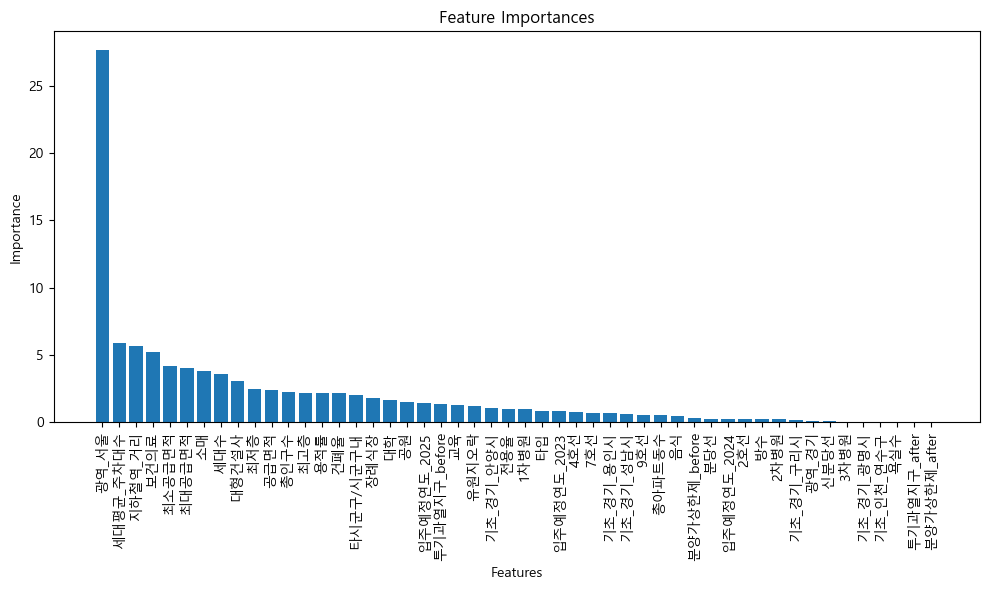

In [75]:
feature_importances = model.feature_importances_
feature_names = X.columns  # Assuming X is a pandas DataFrame with column names

# Sort the features and their importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [76]:
y2_drop_col = ['공급면적']

In [77]:
X = df_y_drop2.drop(y2_drop_col, axis=1)
y = target_df.iloc[:,1]

In [78]:
RFE_50_select_y2 = features_select(using_models[1:2], X, y, selector='RFE', data_results=True)

Selected features for Random Forest: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  35  36  38  45
  49  50  58  59  60  61  62  65  70  72  78  83  89 129]


In [79]:
X = df_y_drop.iloc[:, RFE_50_select_y2['Random Forest']]

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



model = CatBoostRegressor(n_estimators=2500, random_state=42)
model.set_params(**best)

eval_set = [(X_test_scaled, y_test)]

model.fit(X_train_scaled, y_train, eval_set=eval_set, early_stopping_rounds=200) # 디폴트 RMSE
y_pred = model.predict(X_test_scaled)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # RMSE 계산
mae = mean_absolute_error(y_test, y_pred)  # MAE 계산
r2 = r2_score(y_test, y_pred)

print(f"'CatBoost' - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MSE: {mse:.2f}, R2: {r2:.4f}")

0:	learn: 716.8962862	test: 753.1513403	best: 753.1513403 (0)	total: 2.55ms	remaining: 6.38s
1:	learn: 649.5456734	test: 685.3890705	best: 685.3890705 (1)	total: 4.51ms	remaining: 5.63s
2:	learn: 586.1318514	test: 623.9999337	best: 623.9999337 (2)	total: 6.71ms	remaining: 5.58s
3:	learn: 539.1294833	test: 578.1859601	best: 578.1859601 (3)	total: 8.77ms	remaining: 5.47s
4:	learn: 500.9024800	test: 542.6840080	best: 542.6840080 (4)	total: 11.2ms	remaining: 5.57s
5:	learn: 475.0621379	test: 513.9618981	best: 513.9618981 (5)	total: 13ms	remaining: 5.41s
6:	learn: 449.5599193	test: 490.5527722	best: 490.5527722 (6)	total: 15.6ms	remaining: 5.55s
7:	learn: 430.8875248	test: 473.2543423	best: 473.2543423 (7)	total: 17.7ms	remaining: 5.52s
8:	learn: 412.7117062	test: 457.0383625	best: 457.0383625 (8)	total: 20.4ms	remaining: 5.65s
9:	learn: 397.3439175	test: 437.9808410	best: 437.9808410 (9)	total: 22.2ms	remaining: 5.54s
10:	learn: 384.4103627	test: 421.1049817	best: 421.1049817 (10)	total: 2

Shrink model to first 804 iterations.
'CatBoost' - RMSE: 109.09, MAE: 65.79, MSE: 11899.72, R2: 0.9802

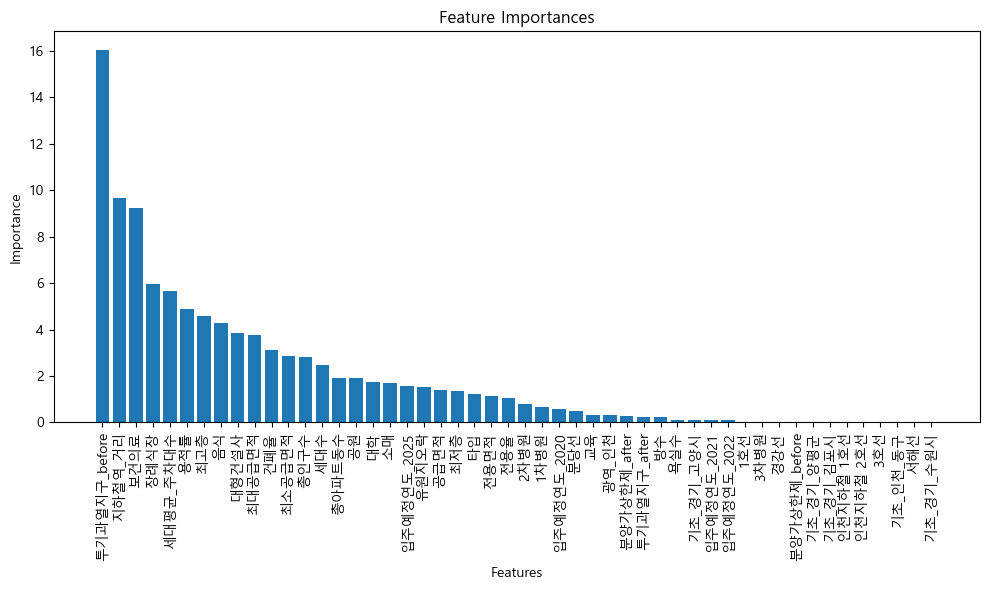

In [81]:
feature_importances = model.feature_importances_
feature_names = X.columns  # Assuming X is a pandas DataFrame with column names

# Sort the features and their importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

Shrink model to first 837 iterations.
CatBoost - RMSE: 130.95, MAE: 72.85, MSE: 17148.07, R2: 0.9714

평당 값은 공급면적이 생각보다 큰 영향을 안줌

하지만 공급액은 공급면적에 큰 영향을 준다.